In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mape', 'rsq'])

# Belgium

## train/test split

In [3]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium = belgium.set_index('date')
belgium.index = pd.to_datetime(belgium.index)
belgium
belgium = belgium.drop('Unnamed: 0', axis=1)

In [4]:
belgium.sort_index()
train_size = int(len(belgium) * 0.7)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
print(belgium_train.shape, belgium_test.shape)

(141, 1) (61, 1)


In [5]:
belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-03-01,NaN,0.0
2020-03-08,NaN,0.0
2020-03-15,NaN,9.0
2020-03-22,NaN,140.0
2020-03-29,NaN,602.0
...,...,...
2023-12-10,0.0,NaN
2023-12-17,0.0,NaN
2023-12-24,0.0,NaN


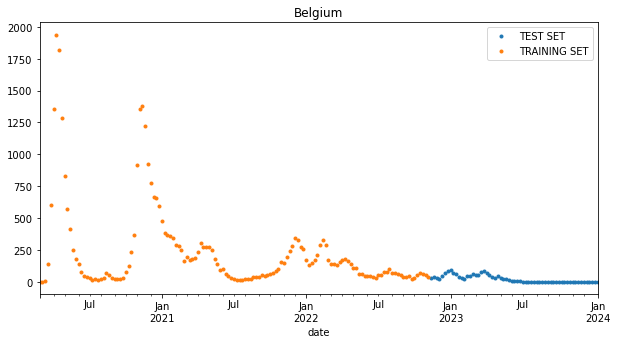

In [6]:
_ = belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Belgium', style='.')

## basic ARIMA (1,0,1)

In [7]:
model=ARIMA(belgium_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -832.504
Date:                Thu, 22 Feb 2024   AIC                           1673.008
Time:                        16:06:07   BIC                           1684.803
Sample:                    03-01-2020   HQIC                          1677.801
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        211.7884    203.043      1.043      0.297    -186.168     609.744
ar.L1          0.8830      0.026     34.162      0.000       0.832       0.934
ma.L1          0.8603      0.061     14.180      0.000       0.741       0.979
sigma2      7649.3102    535.216     14.292      0.000    6600.306    8698.315
===================================================================================
Ljung-Box (L1) (Q):                  16.44   Jarque-Bera (JB):              1725.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

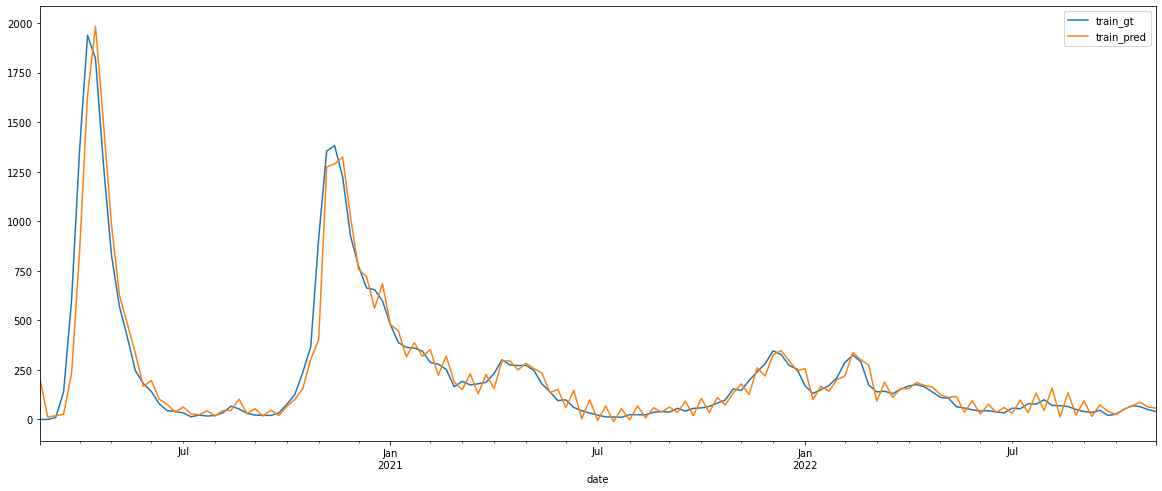

In [8]:
train_pred=model_fit.fittedvalues
pd.concat([belgium_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

<AxesSubplot:xlabel='date'>

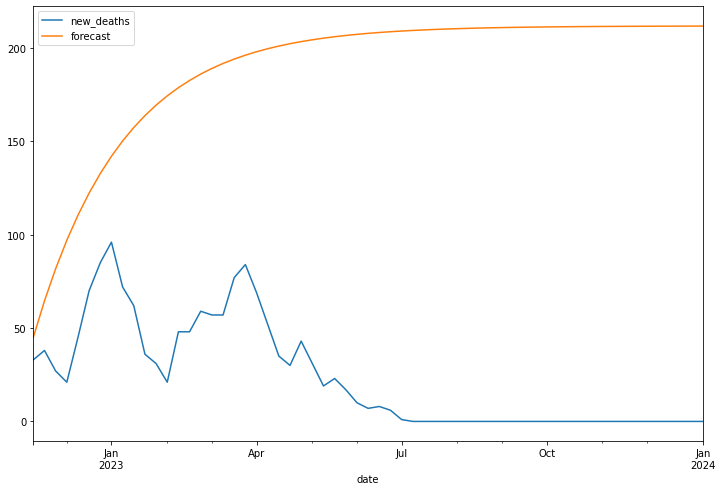

In [9]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [10]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)


In [11]:
metrics

,country,model,mae,mape,rsq
0,Belgium,Basic ARIMA,165.191065,420700992150955136.0,-38.595632


## grid search ARIMA

In [12]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(belgium_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
2,1,3,1620.798576
6,2,3,1622.403203
3,1,4,1622.539132
10,3,3,1623.146503
7,2,4,1624.405232
11,3,4,1625.583947
12,4,1,1628.912059
8,3,1,1629.449759
5,2,2,1629.454643
9,3,2,1629.639760


In [13]:
model=ARIMA(belgium_train['new_deaths'],order=(1,0,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -804.399
Date:                Thu, 22 Feb 2024   AIC                           1620.799
Time:                        16:08:02   BIC                           1638.491
Sample:                    03-01-2020   HQIC                          1627.988
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        233.4577    133.322      1.751      0.080     -27.848     494.763
ar.L1          0.6863      0.051     13.499      0.000       0.587       0.786
ma.L1          1.4308      0.071     20.079      0.000       1.291       1.570
ma.L2          1.1488      0.121      9.465      0.000       0.911       1.387
ma.L3          0.5255      0.109      4.821      0.000       0.312       0.739
sigma2      5094.7025    323.883     15.730      0.000    4459.904    5729.501
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1800.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

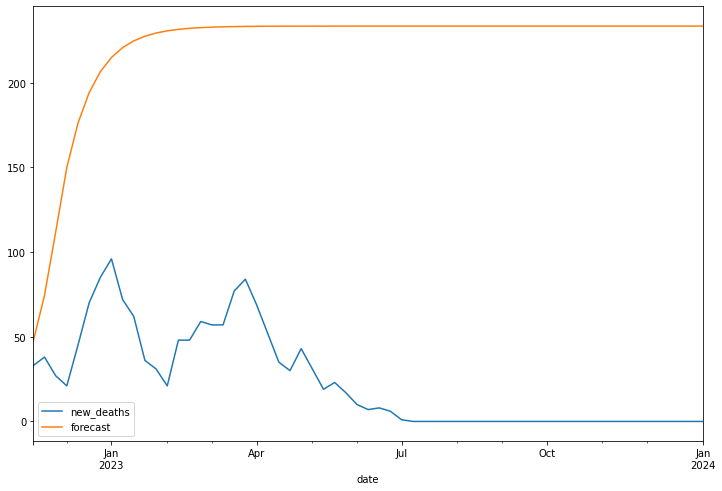

In [14]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [15]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [16]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])



1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65379D+00    |proj g|=  1.77810D+00

At iterate    5    f=  5.91160D+00    |proj g|=  6.78614D-03


 This problem is unconstrained.



At iterate   10    f=  5.90929D+00    |proj g|=  5.06474D-03

At iterate   15    f=  5.90916D+00    |proj g|=  2.31069D-04

At iterate   20    f=  5.90911D+00    |proj g|=  3.67349D-03

At iterate   25    f=  5.90905D+00    |proj g|=  8.22794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     30      1     0     0   6.238D-07   5.909D+00
  F =   5.9090504849881498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.91713D+00    |proj g|=  4.35892D-02

At iterate   10    f=  5.90786D+00    |proj g|=  1.05673D-03

At iterate   15    f=  5.90781D+00    |proj g|=  7.83137D-04

At iterate   20    f=  5.90778D+00    |proj g|=  7.89666D-04

At iterate   25    f=  5.90769D+00    |proj g|=  4.60695D-03

At iterate   30    f=  5.90764D+00    |proj g|=  6.63093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     34      1     0     0   7.244D-06   5.908D+00
  F =   5.9076410015000294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  5.90819D+00    |proj g|=  1.75710D-03

At iterate   15    f=  5.90775D+00    |proj g|=  2.53716D-03

At iterate   20    f=  5.90772D+00    |proj g|=  6.44369D-04

At iterate   25    f=  5.90761D+00    |proj g|=  4.36227D-03

At iterate   30    f=  5.90756D+00    |proj g|=  2.18779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   1.356D-05   5.908D+00
  F =   5.9075636739358863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate   10    f=  5.90940D+00    |proj g|=  1.39357D-02

At iterate   15    f=  5.90811D+00    |proj g|=  2.41424D-03

At iterate   20    f=  5.90785D+00    |proj g|=  7.52226D-04

At iterate   25    f=  5.90745D+00    |proj g|=  5.91211D-03

At iterate   30    f=  5.90633D+00    |proj g|=  2.89828D-03

At iterate   35    f=  5.90589D+00    |proj g|=  2.14551D-03

At iterate   40    f=  5.90456D+00    |proj g|=  2.14985D-03

At iterate   45    f=  5.90440D+00    |proj g|=  9.38677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     55      1     0     0   9.296D-06   5.904D+00
  F =   5.90439605587

 This problem is unconstrained.



At iterate   10    f=  5.85465D+00    |proj g|=  1.82424D-02

At iterate   15    f=  5.84761D+00    |proj g|=  2.75022D-02

At iterate   20    f=  5.82436D+00    |proj g|=  1.74447D-02

At iterate   25    f=  5.80766D+00    |proj g|=  3.72465D-02

At iterate   30    f=  5.80609D+00    |proj g|=  2.11248D-03

At iterate   35    f=  5.80572D+00    |proj g|=  6.15603D-03

At iterate   40    f=  5.80566D+00    |proj g|=  1.99927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     48      1     0     0   5.114D-06   5.806D+00
  F =   5.8056641400647626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.86455D+00    |proj g|=  1.19125D-01

At iterate   10    f=  5.85272D+00    |proj g|=  7.68491D-03

At iterate   15    f=  5.84787D+00    |proj g|=  2.71687D-02

At iterate   20    f=  5.81487D+00    |proj g|=  7.04087D-02

At iterate   25    f=  5.80468D+00    |proj g|=  2.07910D-03

At iterate   30    f=  5.80319D+00    |proj g|=  2.17273D-02

At iterate   35    f=  5.80197D+00    |proj g|=  7.54169D-04

At iterate   40    f=  5.80196D+00    |proj g|=  8.12205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     49      1     0     0   8.122D-05   5.802D+00
  F =   5.80195524815

 This problem is unconstrained.



At iterate    5    f=  5.89758D+00    |proj g|=  1.75853D-01

At iterate   10    f=  5.85448D+00    |proj g|=  3.33753D-02

At iterate   15    f=  5.84978D+00    |proj g|=  2.27334D-02

At iterate   20    f=  5.81022D+00    |proj g|=  5.38474D-02

At iterate   25    f=  5.80284D+00    |proj g|=  4.18223D-03

At iterate   30    f=  5.80177D+00    |proj g|=  3.97555D-03

At iterate   35    f=  5.80170D+00    |proj g|=  1.75380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     39      1     0     0   1.307D-06   5.802D+00
  F =   5.8016950357462145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22317D+00    |proj g|=  1.45947D+00

At iterate    5    f=  5.88749D+00    |proj g|=  8.10944D-02

At iterate   10    f=  5.85392D+00    |proj g|=  1.89276D-02

At iterate   15    f=  5.84573D+00    |proj g|=  3.37549D-02

At iterate   20    f=  5.80711D+00    |proj g|=  7.61235D-03

At iterate   25    f=  5.80700D+00    |proj g|=  2.73887D-03

At iterate   30    f=  5.80592D+00    |proj g|=  3.78342D-03

At iterate   35    f=  5.80585D+00    |proj g|=  6.51289D-04

At iterate   40    f=  5.80554D+00    |proj g|=  1.32268D-02

At iterate   45    f=  5.80495D+00    |proj g|=  8.48468D-04

At iterate   50    f=  5.80494D+00    |proj g|=  1.25207D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90358D+00    |proj g|=  3.94708D-01

At iterate    5    f=  5.78547D+00    |proj g|=  4.75760D-03

At iterate   10    f=  5.78524D+00    |proj g|=  1.93455D-03

At iterate   15    f=  5.78503D+00    |proj g|=  3.88780D-04

At iterate   20    f=  5.78496D+00    |proj g|=  5.00662D-03

At iterate   25    f=  5.78479D+00    |proj g|=  1.25054D-04

At iterate   30    f=  5.78479D+00    |proj g|=  5.48717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14999D+00    |proj g|=  3.87233D-01

At iterate    5    f=  5.78473D+00    |proj g|=  1.01915D-02

At iterate   10    f=  5.78432D+00    |proj g|=  2.82947D-03

At iterate   15    f=  5.78117D+00    |proj g|=  2.46947D-02

At iterate   20    f=  5.77911D+00    |proj g|=  2.51219D-03

At iterate   25    f=  5.77890D+00    |proj g|=  4.02586D-04

At iterate   30    f=  5.77890D+00    |proj g|=  2.18078D-04

At iterate   35    f=  5.77887D+00    |proj g|=  8.32789D-04

At iterate   40    f=  5.77886D+00    |proj g|=  1.27458D-04

At iterate   45    f=  5.77886D+00    |proj g|=  8.15741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91141D+00    |proj g|=  3.18358D-01

At iterate    5    f=  5.78549D+00    |proj g|=  8.10312D-03

At iterate   10    f=  5.78494D+00    |proj g|=  1.54421D-03

At iterate   15    f=  5.78264D+00    |proj g|=  2.07579D-02

At iterate   20    f=  5.77967D+00    |proj g|=  2.87049D-03

At iterate   25    f=  5.77934D+00    |proj g|=  3.07723D-04

At iterate   30    f=  5.77933D+00    |proj g|=  1.64544D-03

At iterate   35    f=  5.77919D+00    |proj g|=  5.90905D-03

At iterate   40    f=  5.77913D+00    |proj g|=  4.88166D-04

At iterate   45    f=  5.77912D+00    |proj g|=  4.12594D-04

At iterate   50    f=  5.77912D+00    |proj g|=  6.89265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.78328D+00    |proj g|=  5.16866D-03

At iterate   10    f=  5.78156D+00    |proj g|=  7.75554D-03

At iterate   15    f=  5.78012D+00    |proj g|=  2.24883D-03

At iterate   20    f=  5.78006D+00    |proj g|=  9.66899D-05

At iterate   25    f=  5.78006D+00    |proj g|=  1.33782D-04

At iterate   30    f=  5.78003D+00    |proj g|=  4.67432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     41      1     0     0   5.639D-05   5.780D+00
  F =   5.7800287905044527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   15    f=  5.79047D+00    |proj g|=  3.29644D-02

At iterate   20    f=  5.76587D+00    |proj g|=  3.37266D-02

At iterate   25    f=  5.76118D+00    |proj g|=  1.57123D-03

At iterate   30    f=  5.76117D+00    |proj g|=  4.42700D-05

At iterate   35    f=  5.76117D+00    |proj g|=  1.39496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     60      1     0     0   1.395D-05   5.761D+00
  F =   5.7611727264075814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16110D+00    |proj g|=  3.54451D-01

At iterate    5    f=  5.82939D+00    |proj g|=  2.53362D-02

At iterate   10    f=  5.82682D+00    |proj g|=  1.72462D-02

At iterate   15    f=  5.79191D+00    |proj g|=  3.35788D-02

At iterate   20    f=  5.76629D+00    |proj g|=  6.75775D-02

At iterate   25    f=  5.76038D+00    |proj g|=  3.50449D-03

At iterate   30    f=  5.75959D+00    |proj g|=  1.82935D-02

At iterate   35    f=  5.75729D+00    |proj g|=  4.73874D-03

At iterate   40    f=  5.75676D+00    |proj g|=  3.35444D-03

At iterate   45    f=  5.75652D+00    |proj g|=  1.83694D-03

At iterate   50    f=  5.75649D+00    |proj g|=  2.65341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored du

 This problem is unconstrained.



At iterate    5    f=  5.82981D+00    |proj g|=  1.75926D-02

At iterate   10    f=  5.82520D+00    |proj g|=  2.30668D-02

At iterate   15    f=  5.77843D+00    |proj g|=  4.33184D-02

At iterate   20    f=  5.75861D+00    |proj g|=  2.06316D-02

At iterate   25    f=  5.75609D+00    |proj g|=  2.30743D-03

At iterate   30    f=  5.75606D+00    |proj g|=  8.37294D-04

At iterate   35    f=  5.75603D+00    |proj g|=  6.41421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     43      1     0     0   3.929D-05   5.756D+00
  F =   5.7560257535220192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15699D+00    |proj g|=  8.47762D-01

At iterate    5    f=  5.82457D+00    |proj g|=  1.28411D-02

At iterate   10    f=  5.80984D+00    |proj g|=  2.01251D-02

At iterate   15    f=  5.75784D+00    |proj g|=  1.36249D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     26      1     0     0   2.904D-03   5.758D+00
  F =   5.7575076913792280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [17]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1638.650709
14,2,2,2,1,1639.199262
13,2,2,1,2,1639.328968
15,2,2,2,2,1641.617169
8,2,1,1,1,1643.311855
9,2,1,1,2,1643.638129
10,2,1,2,1,1643.710755
11,2,1,2,2,1645.968119
4,1,2,1,1,1649.197287
6,1,2,2,1,1650.078000


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95309D+00    |proj g|=  4.11422D-01

At iterate    5    f=  5.82951D+00    |proj g|=  1.43802D-02

At iterate   10    f=  5.82569D+00    |proj g|=  1.86607D-02

At iterate   15    f=  5.79047D+00    |proj g|=  3.29644D-02

At iterate   20    f=  5.76587D+00    |proj g|=  3.37266D-02

At iterate   25    f=  5.76118D+00    |proj g|=  1.57123D-03

At iterate   30    f=  5.76117D+00    |proj g|=  4.42700D-05

At iterate   35    f=  5.76117D+00    |proj g|=  1.39496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:xlabel='date'>

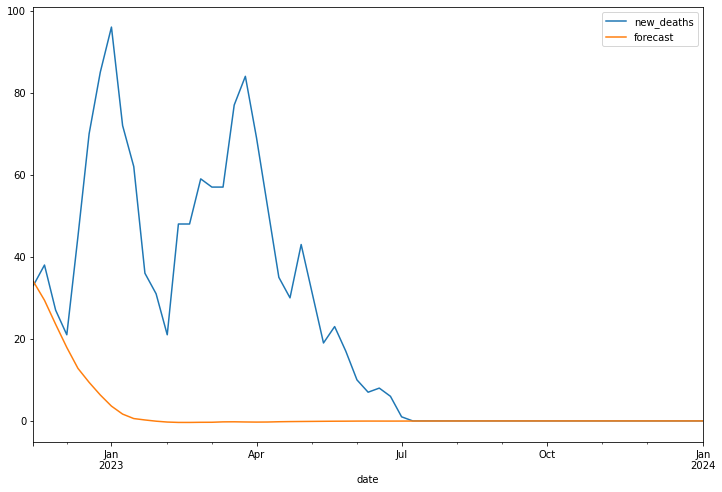

In [18]:
model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(2, 0, 2),seasonal_order=(1,0,1,12))
results=model.fit()
belgium_test['forecast']=results.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [19]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [20]:
auto_model = auto_arima(belgium_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods = len(belgium_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 1, 2)   Log Likelihood                -802.051
Date:                Thu, 22 Feb 2024   AIC                           1618.101
Time:                        16:10:11   BIC                           1638.693
Sample:                    03-01-2020   HQIC                          1626.469
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1013      0.110      9.976      0.000       0.885       1.318
ar.L2          0.1946      0.220      0.885      0.376      -0.236       0.625
ar.L3         -0.8166      0.232     -3.516      0.0

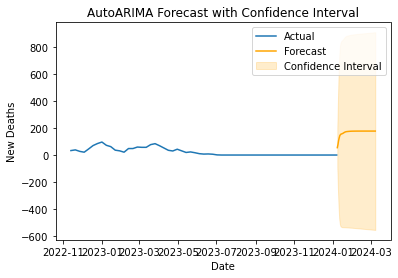

In [21]:
forecast_index = pd.date_range(belgium_test.index[-1], periods=n_periods + 1, freq=belgium_test.index.freq)[-n_periods:]

plt.plot(belgium_test.index, belgium_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [22]:
mae = mean_absolute_error(belgium_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(belgium_test['new_deaths'], forecast)
r2 = r2_score(belgium_test['new_deaths'], forecast)
new_row = {'country': 'Belgium', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Chile

## train/test split

In [23]:
chile = pd.read_csv('univariate_df_Chile.csv')
chile = chile.set_index('date')
chile.index = pd.to_datetime(chile.index)
chile = chile.drop('Unnamed: 0', axis=1)

In [24]:
chile.sort_index()
train_size = int(len(chile) * 0.7)
chile_train, chile_test = chile[0:train_size], belgium[train_size:]
print(chile_train.shape, chile_test.shape)

(141, 1) (61, 1)


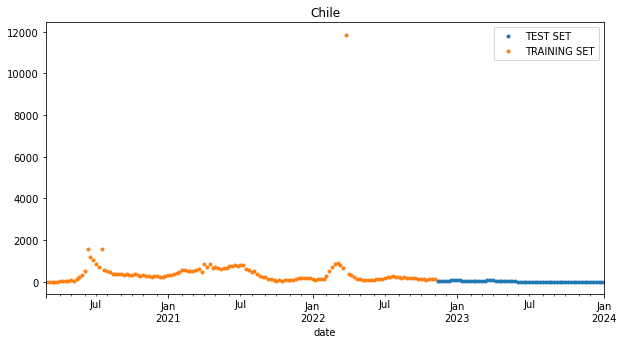

In [25]:
_ = chile_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(chile_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Chile', style='.')

## basic ARIMA (1,0,1)

In [26]:
model=ARIMA(chile_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1174.009
Date:                Thu, 22 Feb 2024   AIC                           2356.018
Time:                        16:10:50   BIC                           2367.813
Sample:                    03-01-2020   HQIC                          2360.811
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        438.2168    466.712      0.939      0.348    -476.522    1352.956
ar.L1          0.7085      0.660      1.073      0.283      -0.585       2.002
ma.L1         -0.6115      0.687     -0.890      0.374      -1.959       0.736
sigma2      1.023e+06   6.14e+04     16.655      0.000    9.03e+05    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             80252.95
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              28.79   Skew:                            10.39
Prob(H) (two-sided):                  0.00   Kurtosis:                       118.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

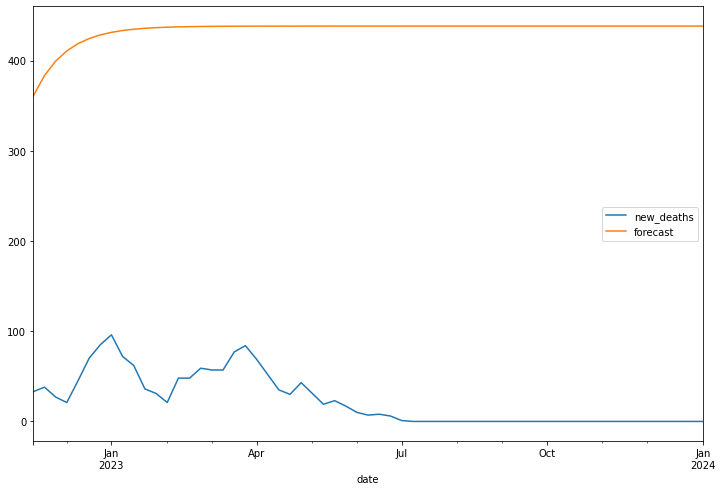

In [27]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [28]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [29]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(chile_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
5,2,2,2346.802121
9,3,2,2350.253052
6,2,3,2350.468350
7,2,4,2354.412644
13,4,2,2355.642824
0,1,1,2356.018009
4,2,1,2357.821757
1,1,2,2357.927563
14,4,3,2358.078996
11,3,4,2358.463948


In [30]:
model=ARIMA(chile_train['new_deaths'],order=(2,0,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1167.401
Date:                Thu, 22 Feb 2024   AIC                           2346.802
Time:                        16:11:41   BIC                           2364.495
Sample:                    03-01-2020   HQIC                          2353.992
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        481.1356     66.087      7.280      0.000     351.608     610.663
ar.L1          1.9418      0.058     33.620      0.000       1.829       2.055
ar.L2         -0.9597      0.058    -16.485      0.000      -1.074      -0.846
ma.L1         -1.9946      0.113    -17.663      0.000      -2.216      -1.773
ma.L2          0.9988      0.113      8.871      0.000       0.778       1.219
sigma2      8.723e+05      0.000   6.05e+09      0.000    8.72e+05    8.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             71395.95
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              23.01   Skew:                             9.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       111.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.79e+26. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

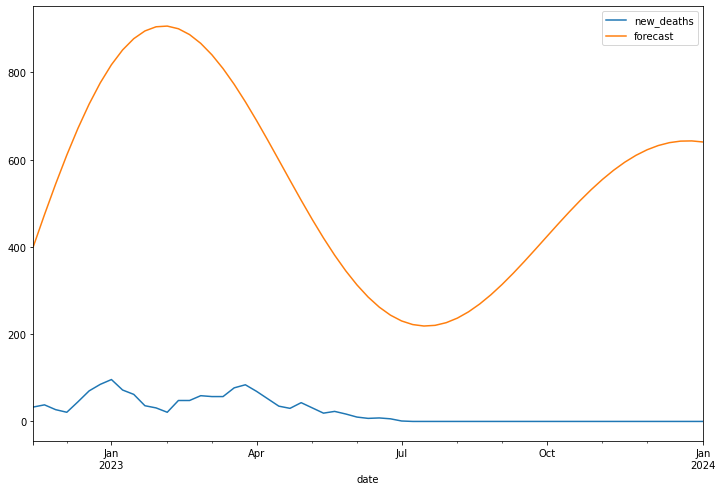

In [31]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [32]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [33]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36159D+00    |proj g|=  3.73411D-02

At iterate    5    f=  8.35257D+00    |proj g|=  6.03983D-04


 This problem is unconstrained.



At iterate   10    f=  8.35197D+00    |proj g|=  9.33984D-03

At iterate   15    f=  8.35086D+00    |proj g|=  3.91232D-04

At iterate   20    f=  8.35085D+00    |proj g|=  6.87143D-04

At iterate   25    f=  8.35084D+00    |proj g|=  1.05997D-04

At iterate   30    f=  8.35077D+00    |proj g|=  1.96426D-03

At iterate   35    f=  8.35012D+00    |proj g|=  1.21184D-03

At iterate   40    f=  8.35006D+00    |proj g|=  2.03982D-04

At iterate   45    f=  8.35005D+00    |proj g|=  1.98312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     58      1     0     0   7.669D-06   8.350D+00
  F =   8.35005099148

 This problem is unconstrained.



At iterate   10    f=  8.35242D+00    |proj g|=  1.40909D-03

At iterate   15    f=  8.35064D+00    |proj g|=  4.58924D-03

At iterate   20    f=  8.35057D+00    |proj g|=  2.68886D-04

At iterate   25    f=  8.35056D+00    |proj g|=  8.36928D-04

At iterate   30    f=  8.35053D+00    |proj g|=  6.59277D-04

At iterate   35    f=  8.35053D+00    |proj g|=  1.38571D-04

At iterate   40    f=  8.35031D+00    |proj g|=  1.54039D-02

At iterate   45    f=  8.34999D+00    |proj g|=  4.61513D-04

At iterate   50    f=  8.34991D+00    |proj g|=  2.26990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

 This problem is unconstrained.



At iterate    5    f=  8.35259D+00    |proj g|=  1.74192D-03

At iterate   10    f=  8.35233D+00    |proj g|=  4.51627D-03

At iterate   15    f=  8.35071D+00    |proj g|=  4.35155D-03

At iterate   20    f=  8.35069D+00    |proj g|=  5.37962D-04

At iterate   25    f=  8.35059D+00    |proj g|=  4.78715D-03

At iterate   30    f=  8.35056D+00    |proj g|=  5.30543D-05

At iterate   35    f=  8.35048D+00    |proj g|=  2.27243D-03

At iterate   40    f=  8.34995D+00    |proj g|=  7.63023D-04

At iterate   45    f=  8.34993D+00    |proj g|=  2.20922D-03

At iterate   50    f=  8.34985D+00    |proj g|=  8.67811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.35402D+00    |proj g|=  2.03995D-02

At iterate   10    f=  8.35216D+00    |proj g|=  2.47974D-03

At iterate   15    f=  8.35091D+00    |proj g|=  4.50256D-03

At iterate   20    f=  8.35024D+00    |proj g|=  2.69724D-03

At iterate   25    f=  8.35013D+00    |proj g|=  1.16327D-02

At iterate   30    f=  8.35005D+00    |proj g|=  9.16159D-04

At iterate   35    f=  8.34993D+00    |proj g|=  9.04613D-04

At iterate   40    f=  8.34988D+00    |proj g|=  2.86769D-03

At iterate   45    f=  8.34968D+00    |proj g|=  6.38311D-03

At iterate   50    f=  8.34961D+00    |proj g|=  1.48480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.35125D+00    |proj g|=  4.64030D-03

At iterate   15    f=  8.35118D+00    |proj g|=  8.05416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   6.013D-05   8.351D+00
  F =   8.3511834499532558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35863D+00    |proj g|=  5.87319D-02

At iterate    5    f=  8.35102D+00    |proj g|=  4.75881D-03

At iterate   10    f=  8.35099D+00    |proj g|=  1.15234D-03

At iterate   15    f=  8.35084D+00    |proj g|=  8.57547D-03

At iterate   20    f=  8.35079D+00    |proj g|=  1.42175D-04

At iterate   25    f=  8.35079D+00    |proj g|=  6.32575D-04

At iterate   30    f=  8.35076D+00    |proj g|=  6.57172D-04

At iterate   35    f=  8.35076D+00    |proj g|=  9.01787D-05

At iterate   40    f=  8.35075D+00    |proj g|=  7.88084D-04

At iterate   45    f=  8.35063D+00    |proj g|=  3.20084D-03

At iterate   50    f=  8.35052D+00    |proj g|=  8.64148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.35105D+00    |proj g|=  2.28536D-03

At iterate   10    f=  8.35102D+00    |proj g|=  3.78820D-03

At iterate   15    f=  8.35085D+00    |proj g|=  9.71575D-04

At iterate   20    f=  8.35085D+00    |proj g|=  8.80378D-04

At iterate   25    f=  8.35079D+00    |proj g|=  9.10428D-04

At iterate   30    f=  8.35079D+00    |proj g|=  6.07095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     34      1     0     0   6.071D-05   8.351D+00
  F =   8.3507885573601062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  8.35091D+00    |proj g|=  6.88085D-03

At iterate   10    f=  8.35077D+00    |proj g|=  3.59973D-03

At iterate   15    f=  8.35002D+00    |proj g|=  1.22188D-02

At iterate   20    f=  8.34993D+00    |proj g|=  2.54749D-04

At iterate   25    f=  8.34988D+00    |proj g|=  2.33647D-03

At iterate   30    f=  8.34987D+00    |proj g|=  1.86808D-04

At iterate   35    f=  8.34985D+00    |proj g|=  4.35821D-04

At iterate   40    f=  8.34984D+00    |proj g|=  1.54843D-04

At iterate   45    f=  8.34984D+00    |proj g|=  9.17733D-04

At iterate   50    f=  8.34970D+00    |proj g|=  1.26659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.35109D+00    |proj g|=  4.49389D-03

At iterate   15    f=  8.35093D+00    |proj g|=  5.26095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   5.261D-05   8.351D+00
  F =   8.3509299053438397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36096D+00    |proj g|=  5.24467D-02


 This problem is unconstrained.



At iterate    5    f=  8.35152D+00    |proj g|=  2.34055D-02

At iterate   10    f=  8.35089D+00    |proj g|=  6.28108D-04

At iterate   15    f=  8.35071D+00    |proj g|=  1.02563D-02

At iterate   20    f=  8.35052D+00    |proj g|=  1.43484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     25      1     0     0   7.405D-05   8.351D+00
  F =   8.3505210119242399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  8.35098D+00    |proj g|=  5.22729D-03

At iterate   10    f=  8.35092D+00    |proj g|=  1.69278D-03

At iterate   15    f=  8.35058D+00    |proj g|=  2.09643D-03

At iterate   20    f=  8.35057D+00    |proj g|=  1.25890D-04

At iterate   25    f=  8.35055D+00    |proj g|=  1.64752D-03

At iterate   30    f=  8.35053D+00    |proj g|=  3.88659D-04

At iterate   35    f=  8.35053D+00    |proj g|=  1.35556D-04

At iterate   40    f=  8.35052D+00    |proj g|=  3.49011D-04

At iterate   45    f=  8.35040D+00    |proj g|=  1.06501D-02

At iterate   50    f=  8.35002D+00    |proj g|=  2.27549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.35127D+00    |proj g|=  1.77013D-02

At iterate   10    f=  8.35068D+00    |proj g|=  1.80040D-03

At iterate   15    f=  8.35014D+00    |proj g|=  1.31214D-02

At iterate   20    f=  8.34975D+00    |proj g|=  2.57716D-03

At iterate   25    f=  8.34974D+00    |proj g|=  4.19860D-04

At iterate   30    f=  8.34961D+00    |proj g|=  2.15371D-03

At iterate   35    f=  8.34960D+00    |proj g|=  3.30381D-04

At iterate   40    f=  8.34957D+00    |proj g|=  1.03882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     53      1     0     0   5.725D-05   8.350D+00
  F =   8.34956134811

 This problem is unconstrained.



At iterate    5    f=  8.35123D+00    |proj g|=  9.45245D-04

At iterate   10    f=  8.35110D+00    |proj g|=  8.79520D-05

At iterate   15    f=  8.35109D+00    |proj g|=  2.15457D-03

At iterate   20    f=  8.35099D+00    |proj g|=  2.44422D-03

At iterate   25    f=  8.35091D+00    |proj g|=  1.88204D-03

At iterate   30    f=  8.35063D+00    |proj g|=  1.67916D-02

At iterate   35    f=  8.34388D+00    |proj g|=  6.59810D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  8.34363D+00    |proj g|=  1.28096D-03

At iterate   45    f=  8.34351D+00    |proj g|=  5.08871D-03

At iterate   50    f=  8.34341D+00    |proj g|=  1.14843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     92      2     0     0   1.148D-03   8.343D+00
  F =   8.3434093435135139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35845D+00    |proj g|=  5.83728D-02


 This problem is unconstrained.



At iterate    5    f=  8.35097D+00    |proj g|=  2.29353D-03

At iterate   10    f=  8.35075D+00    |proj g|=  4.99733D-03

At iterate   15    f=  8.35072D+00    |proj g|=  3.10693D-04

At iterate   20    f=  8.35070D+00    |proj g|=  1.37850D-03

At iterate   25    f=  8.35068D+00    |proj g|=  3.61115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   5.878D-05   8.351D+00
  F =   8.3506838648096995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  8.35099D+00    |proj g|=  2.54009D-03

At iterate   10    f=  8.35082D+00    |proj g|=  2.29231D-03

At iterate   15    f=  8.35077D+00    |proj g|=  1.72445D-03

At iterate   20    f=  8.35071D+00    |proj g|=  2.17815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     26      1     0     0   5.871D-05   8.351D+00
  F =   8.3507128535401378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  8.35079D+00    |proj g|=  2.29590D-03

At iterate   10    f=  8.35045D+00    |proj g|=  5.18735D-03

At iterate   15    f=  8.35024D+00    |proj g|=  8.05399D-03

At iterate   20    f=  8.34981D+00    |proj g|=  3.44794D-03

At iterate   25    f=  8.34978D+00    |proj g|=  1.97862D-04

At iterate   30    f=  8.34977D+00    |proj g|=  1.06395D-03

At iterate   35    f=  8.34976D+00    |proj g|=  1.26507D-04

At iterate   40    f=  8.34976D+00    |proj g|=  3.17709D-04

At iterate   45    f=  8.34972D+00    |proj g|=  2.13385D-03

At iterate   50    f=  8.34951D+00    |proj g|=  7.17790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [34]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
0,1,1,1,1,2364.714380
2,1,1,2,1,2366.658570
1,1,1,1,2,2366.675872
12,2,2,1,1,2366.841435
8,2,1,1,1,2366.962233
4,1,2,1,1,2367.033733
3,1,1,2,2,2368.588980
10,2,1,2,1,2368.705660
9,2,1,1,2,2368.846925
5,1,2,1,2,2368.847875


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36159D+00    |proj g|=  3.73411D-02

At iterate    5    f=  8.35257D+00    |proj g|=  6.03983D-04

At iterate   10    f=  8.35197D+00    |proj g|=  9.33984D-03

At iterate   15    f=  8.35086D+00    |proj g|=  3.91232D-04

At iterate   20    f=  8.35085D+00    |proj g|=  6.87143D-04

At iterate   25    f=  8.35084D+00    |proj g|=  1.05997D-04

At iterate   30    f=  8.35077D+00    |proj g|=  1.96426D-03

At iterate   35    f=  8.35012D+00    |proj g|=  1.21184D-03

At iterate   40    f=  8.35006D+00    |proj g|=  2.03982D-04

At iterate   45    f=  8.35005D+00    |proj g|=  1.98312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<AxesSubplot:xlabel='date'>

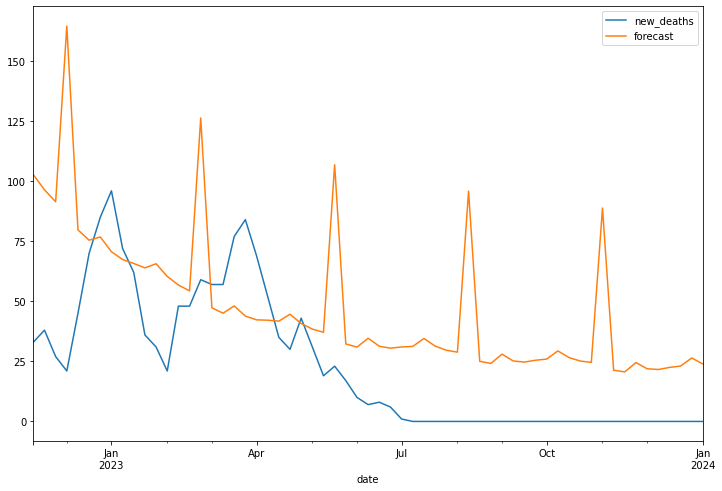

In [35]:
model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(1, 0, 1),seasonal_order=(1,0,1,12))
results=model.fit()
chile_test['forecast']=results.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [36]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
mape = mean_absolute_percentage_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
new_row = {'country': 'Chile', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [37]:
auto_model = auto_arima(chile_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(chile_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:                        SARIMAX   Log Likelihood               -1175.312
Date:                Thu, 22 Feb 2024   AIC                           2354.623
Time:                        16:13:36   BIC                           2360.521
Sample:                    03-01-2020   HQIC                          2357.020
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    438.2199    298.221      1.469      0.142    -146.283    1022.723
sigma2      1.018e+06    5.6e+04     18.175      0.000    9.08e+05    1.13e+06
Ljung-Box (L1) (Q):                   1.19   Jarque-

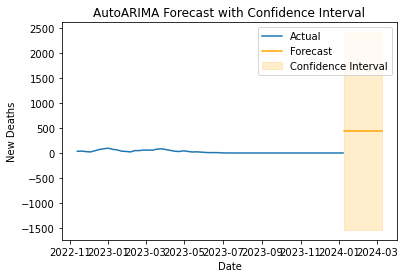

In [38]:
forecast_index = pd.date_range(chile_test.index[-1], periods=n_periods + 1, freq=chile_test.index.freq)[-n_periods:]

plt.plot(chile_test.index, chile_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [39]:
mae = mean_absolute_error(chile_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(chile_test['new_deaths'], forecast)
r2 = r2_score(chile_test['new_deaths'], forecast)
new_row = {'country': 'Chile', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Ireland

## train/test split

In [40]:
ireland = pd.read_csv('univariate_df_Ireland.csv')
ireland = ireland.set_index('date')
ireland.index = pd.to_datetime(ireland.index)
ireland = ireland.drop('Unnamed: 0', axis=1)

In [41]:
ireland.sort_index()
train_size = int(len(ireland) * 0.7)
ireland_train, ireland_test = ireland[0:train_size], ireland[train_size:]
print(ireland_train.shape, ireland_test.shape)

(141, 1) (61, 1)


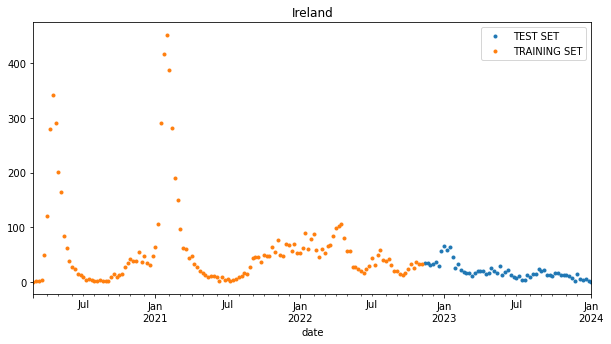

In [42]:
_ = ireland_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(ireland_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Ireland', style='.')

## basic ARIMA (1,0,1)

In [43]:
model=ARIMA(ireland_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -662.637
Date:                Thu, 22 Feb 2024   AIC                           1333.275
Time:                        16:14:09   BIC                           1345.070
Sample:                    03-01-2020   HQIC                          1338.068
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.7532     40.098      1.365      0.172     -23.838     133.344
ar.L1          0.8634      0.037     23.349      0.000       0.791       0.936
ma.L1          0.5461      0.063      8.637      0.000       0.422       0.670
sigma2       694.7326     37.626     18.464      0.000     620.988     768.477
===================================================================================
Ljung-Box (L1) (Q):                   5.91   Jarque-Bera (JB):              1816.25
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             2.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

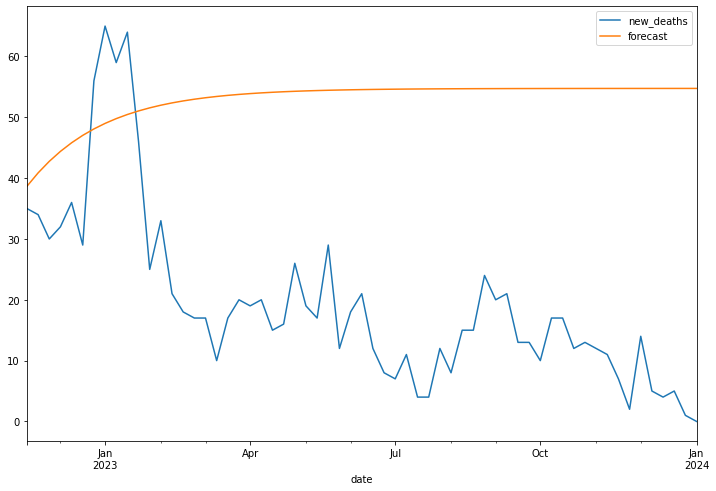

In [44]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [45]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [46]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(ireland_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
7,2,4,1307.792020
12,4,1,1307.976061
4,2,1,1309.206180
11,3,4,1309.754951
3,1,4,1310.056604
10,3,3,1310.179709
5,2,2,1310.710871
8,3,1,1310.775047
13,4,2,1311.161055
6,2,3,1312.355228


In [47]:
model=ARIMA(ireland_train['new_deaths'],order=(2,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -645.469
Date:                Thu, 22 Feb 2024   AIC                           1304.937
Time:                        16:15:15   BIC                           1325.529
Sample:                    03-01-2020   HQIC                          1313.305
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2584      0.272      4.623      0.000       0.725       1.792
ar.L2         -0.4507      0.237     -1.899      0.058      -0.916       0.015
ma.L1         -0.7013     12.858     -0.055      0.957     -25.902      24.500
ma.L2         -0.0793      3.928     -0.020      0.984      -7.777       7.619
ma.L3         -0.1239      2.852     -0.043      0.965      -5.714       5.467
ma.L4         -0.0954      1.303     -0.073      0.942      -2.650       2.459
sigma2       576.1042   7453.833      0.077      0.938    -1.4e+04    1.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1856.93
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

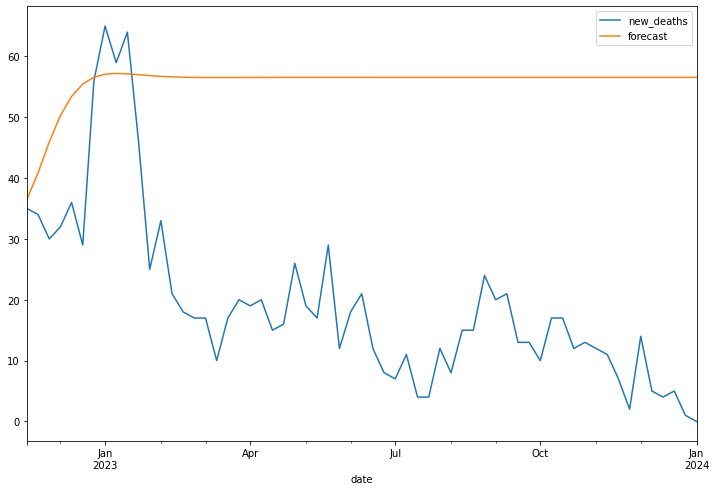

In [48]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [49]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [50]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82022D+00    |proj g|=  2.73274D-01

At iterate    5    f=  4.71325D+00    |proj g|=  4.86249D-03

At iterate   10    f=  4.71249D+00    |proj g|=  8.94283D-03


 This problem is unconstrained.



At iterate   15    f=  4.71192D+00    |proj g|=  3.13703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.966D-05   4.712D+00
  F =   4.7119165868353061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13575D+00    |proj g|=  7.73120D-01

At iterate    5    f=  4.70995D+00    |proj g|=  3.89768D-03

At iterate   10    f=  4.70922D+00    |proj g|=  5.06407D-03

At iterate   15    f=  4.70803D+00    |proj g|=  5.41211D-04

At iterate   20    f=  4.70776D+00    |proj g|=  2.56707D-03

At iterate   25    f=  4.70738D+00    |proj g|=  1.91678D-03

At iterate   30    f=  4.70721D+00    |proj g|=  1.62683D-03

At iterate   35    f=  4.70715D+00    |proj g|=  1.69123D-03

At iterate   40    f=  4.70713D+00    |proj g|=  2.64411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  4.71245D+00    |proj g|=  3.74894D-03

At iterate   10    f=  4.71181D+00    |proj g|=  3.08130D-03

At iterate   15    f=  4.71104D+00    |proj g|=  1.11510D-03

At iterate   20    f=  4.71094D+00    |proj g|=  5.85935D-03

At iterate   25    f=  4.71010D+00    |proj g|=  1.82601D-02

At iterate   30    f=  4.70785D+00    |proj g|=  7.22447D-03

At iterate   35    f=  4.70735D+00    |proj g|=  8.41564D-04

At iterate   40    f=  4.70722D+00    |proj g|=  7.90892D-04

At iterate   45    f=  4.70719D+00    |proj g|=  1.14702D-03

At iterate   50    f=  4.70718D+00    |proj g|=  3.75130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.71093D+00    |proj g|=  2.33096D-02

At iterate   10    f=  4.70937D+00    |proj g|=  5.44737D-03

At iterate   15    f=  4.70789D+00    |proj g|=  2.57216D-03

At iterate   20    f=  4.70778D+00    |proj g|=  9.96264D-04

At iterate   25    f=  4.70752D+00    |proj g|=  2.20954D-03

At iterate   30    f=  4.70734D+00    |proj g|=  1.74912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     43      1     0     0   1.122D-02   4.707D+00
  F =   4.7071218719647021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  4.65660D+00    |proj g|=  1.99677D-02

At iterate   15    f=  4.65404D+00    |proj g|=  4.22991D-04

At iterate   20    f=  4.65396D+00    |proj g|=  2.06184D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f=  4.65394D+00    |proj g|=  7.41949D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     49      2     0     0   7.419D-06   4.654D+00
  F =   4.6539443347648559     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14360D+00    |proj g|=  8.79316D-01

At iterate    5    f=  4.65124D+00    |proj g|=  1.69605D-02

At iterate   10    f=  4.65004D+00    |proj g|=  6.86925D-03


 This problem is unconstrained.



At iterate    5    f=  4.65873D+00    |proj g|=  1.06248D-02

At iterate   10    f=  4.65427D+00    |proj g|=  1.74561D-02

At iterate   15    f=  4.65031D+00    |proj g|=  2.36960D-03

At iterate   20    f=  4.64816D+00    |proj g|=  4.63369D-03

At iterate   25    f=  4.64765D+00    |proj g|=  2.25988D-03

At iterate   30    f=  4.64752D+00    |proj g|=  1.04557D-03

At iterate   35    f=  4.64751D+00    |proj g|=  2.74064D-04

At iterate   40    f=  4.64751D+00    |proj g|=  1.01792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     53      1     0     0   3.830D-05   4.648D+00
  F =   4.64750822068

 This problem is unconstrained.



At iterate    5    f=  4.65562D+00    |proj g|=  2.69404D-02

At iterate   10    f=  4.65251D+00    |proj g|=  7.31130D-03

At iterate   15    f=  4.64917D+00    |proj g|=  7.83235D-03

At iterate   20    f=  4.64829D+00    |proj g|=  4.39806D-03

At iterate   25    f=  4.64570D+00    |proj g|=  1.81975D-02

At iterate   30    f=  4.64499D+00    |proj g|=  1.07260D-03

At iterate   35    f=  4.64498D+00    |proj g|=  4.92738D-04

At iterate   40    f=  4.64491D+00    |proj g|=  2.46729D-03

At iterate   45    f=  4.64491D+00    |proj g|=  4.01466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     56   

 This problem is unconstrained.



At iterate    5    f=  4.63995D+00    |proj g|=  3.68576D-03

At iterate   10    f=  4.63989D+00    |proj g|=  1.90274D-03

At iterate   15    f=  4.63868D+00    |proj g|=  1.44603D-02

At iterate   20    f=  4.63154D+00    |proj g|=  8.42008D-03

At iterate   25    f=  4.62935D+00    |proj g|=  2.87730D-03

At iterate   30    f=  4.62878D+00    |proj g|=  1.38632D-03

At iterate   35    f=  4.62859D+00    |proj g|=  2.01103D-03

At iterate   40    f=  4.62856D+00    |proj g|=  1.48004D-03

At iterate   45    f=  4.62855D+00    |proj g|=  4.21341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     64   

 This problem is unconstrained.



At iterate    5    f=  4.62503D+00    |proj g|=  1.00982D-02

At iterate   10    f=  4.62362D+00    |proj g|=  2.69425D-03

At iterate   15    f=  4.62221D+00    |proj g|=  1.30307D-03

At iterate   20    f=  4.62216D+00    |proj g|=  2.88724D-03

At iterate   25    f=  4.62203D+00    |proj g|=  5.77099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     33      1     0     0   4.472D-05   4.622D+00
  F =   4.6220246215594498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  4.63726D+00    |proj g|=  7.01063D-03

At iterate   10    f=  4.63086D+00    |proj g|=  2.95653D-02

At iterate   15    f=  4.62383D+00    |proj g|=  3.58501D-03

At iterate   20    f=  4.62342D+00    |proj g|=  2.68111D-04

At iterate   25    f=  4.62341D+00    |proj g|=  6.13875D-04

At iterate   30    f=  4.62339D+00    |proj g|=  3.60886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     37      1     0     0   7.509D-06   4.623D+00
  F =   4.6233902511550458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.62931D+00    |proj g|=  1.81505D-02

At iterate   10    f=  4.62772D+00    |proj g|=  7.50058D-03

At iterate   15    f=  4.62181D+00    |proj g|=  2.37113D-02

At iterate   20    f=  4.61968D+00    |proj g|=  2.68706D-03

At iterate   25    f=  4.61919D+00    |proj g|=  1.78241D-03

At iterate   30    f=  4.61917D+00    |proj g|=  1.25776D-03

At iterate   35    f=  4.61917D+00    |proj g|=  1.79630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     42      1     0     0   1.563D-05   4.619D+00
  F =   4.6191650670404139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.64389D+00    |proj g|=  1.53922D-02

At iterate   10    f=  4.63663D+00    |proj g|=  3.90757D-02

At iterate   15    f=  4.63534D+00    |proj g|=  2.56886D-03

At iterate   20    f=  4.63531D+00    |proj g|=  1.01883D-03

At iterate   25    f=  4.63516D+00    |proj g|=  1.47134D-03

At iterate   30    f=  4.63514D+00    |proj g|=  1.11409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     37      1     0     0   9.299D-06   4.635D+00
  F =   4.6351429852525401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.62439D+00    |proj g|=  8.27440D-03

At iterate   10    f=  4.62273D+00    |proj g|=  8.68568D-03

At iterate   15    f=  4.61966D+00    |proj g|=  5.44995D-03

At iterate   20    f=  4.61962D+00    |proj g|=  1.59714D-04

At iterate   25    f=  4.61960D+00    |proj g|=  5.33388D-04

At iterate   30    f=  4.61960D+00    |proj g|=  3.53950D-05

At iterate   35    f=  4.61960D+00    |proj g|=  5.35092D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     39      1     0     0   5.351D-06   4.620D+00
  F =   4.6195981819029193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.64117D+00    |proj g|=  9.14581D-03

At iterate   10    f=  4.62451D+00    |proj g|=  2.55632D-02

At iterate   15    f=  4.62246D+00    |proj g|=  3.95629D-03

At iterate   20    f=  4.62192D+00    |proj g|=  8.60963D-03

At iterate   25    f=  4.62113D+00    |proj g|=  1.17170D-03

At iterate   30    f=  4.62112D+00    |proj g|=  2.78997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     37      1     0     0   3.790D-05   4.621D+00
  F =   4.6211208226492468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.63046D+00    |proj g|=  1.79055D-02

At iterate   10    f=  4.62743D+00    |proj g|=  1.12130D-02

At iterate   15    f=  4.61949D+00    |proj g|=  5.44752D-03

At iterate   20    f=  4.61681D+00    |proj g|=  7.18330D-03

At iterate   25    f=  4.61605D+00    |proj g|=  8.61959D-04

At iterate   30    f=  4.61603D+00    |proj g|=  8.26498D-04

At iterate   35    f=  4.61601D+00    |proj g|=  2.91217D-04

At iterate   40    f=  4.61601D+00    |proj g|=  1.81196D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     43      1     0     0   1.812D-05   4.616D+00
  F =   4.61601160840

In [51]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1317.250536
9,2,1,1,2,1317.410943
10,2,1,2,1,1317.796051
11,2,1,2,2,1318.604549
13,2,2,1,2,1318.726687
14,2,2,2,1,1319.156072
15,2,2,2,2,1319.715274
12,2,2,1,1,1321.110322
4,1,2,1,1,1324.412302
5,1,2,1,2,1324.469779


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68706D+00    |proj g|=  2.78353D-01



At iterate    5    f=  4.63995D+00    |proj g|=  3.68576D-03

At iterate   10    f=  4.63989D+00    |proj g|=  1.90274D-03

At iterate   15    f=  4.63868D+00    |proj g|=  1.44603D-02

At iterate   20    f=  4.63154D+00    |proj g|=  8.42008D-03

At iterate   25    f=  4.62935D+00    |proj g|=  2.87730D-03

At iterate   30    f=  4.62878D+00    |proj g|=  1.38632D-03

At iterate   35    f=  4.62859D+00    |proj g|=  2.01103D-03

At iterate   40    f=  4.62856D+00    |proj g|=  1.48004D-03

At iterate   45    f=  4.62855D+00    |proj g|=  4.21341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     64   

<AxesSubplot:xlabel='date'>

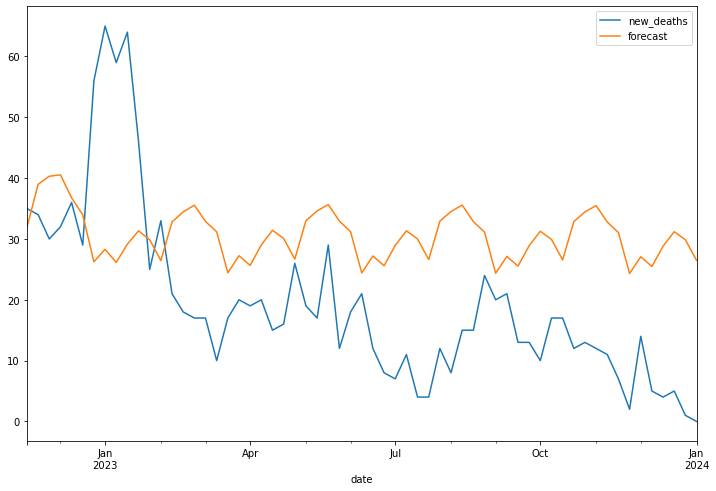

In [52]:
model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(2, 0, 1),seasonal_order=(1,0,1,12))
results=model.fit()
ireland_test['forecast']=results.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [53]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
new_row = {'country': 'Ireland', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [54]:
auto_model = auto_arima(ireland_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(ireland_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -649.850
Date:                Thu, 22 Feb 2024   AIC                           1307.700
Time:                        16:17:12   BIC                           1319.495
Sample:                    03-01-2020   HQIC                          1312.493
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.2423      4.251      1.939      0.052      -0.089      16.573
ar.L1          1.5153      0.050     30.475      0.000       1.418       1.613
ar.L2         -0.6593      0.050    -13.281      0.0

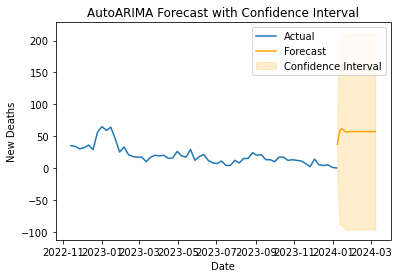

In [55]:
forecast_index = pd.date_range(ireland_test.index[-1], periods=n_periods + 1, freq=ireland_test.index.freq)[-n_periods:]

plt.plot(ireland_test.index, ireland_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [56]:
mae = mean_absolute_error(ireland_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(ireland_test['new_deaths'], forecast)
r2 = r2_score(ireland_test['new_deaths'], forecast)
new_row = {'country': 'Ireland', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Israel

## train/test split

In [57]:
israel = pd.read_csv('univariate_df_Israel.csv')
israel = israel.set_index('date')
israel.index = pd.to_datetime(israel.index)
israel = israel.drop('Unnamed: 0', axis=1)
israel.sort_index()
train_size = int(len(israel) * 0.7)
israel_train, israel_test = israel[0:train_size], israel[train_size:]
print(israel_train.shape, israel_test.shape)

(141, 1) (61, 1)


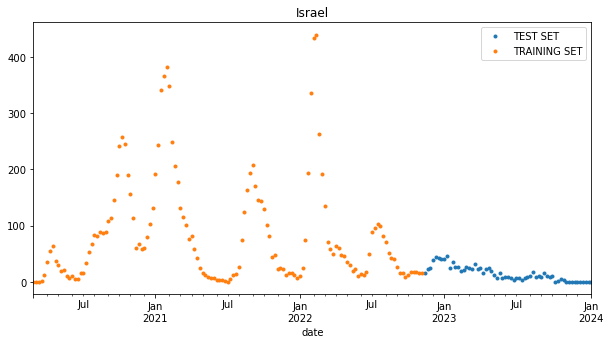

In [58]:
_ = israel_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(israel_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Israel', style='.')

## basic ARIMA (1,0,1)

In [59]:
model=ARIMA(israel_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -663.910
Date:                Thu, 22 Feb 2024   AIC                           1335.820
Time:                        16:17:48   BIC                           1347.615
Sample:                    03-01-2020   HQIC                          1340.613
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1845     52.210      1.440      0.150     -27.146     177.515
ar.L1          0.8940      0.030     30.206      0.000       0.836       0.952
ma.L1          0.6143      0.051     11.947      0.000       0.514       0.715
sigma2       705.0885     46.688     15.102      0.000     613.582     796.595
===================================================================================
Ljung-Box (L1) (Q):                   5.67   Jarque-Bera (JB):               323.88
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

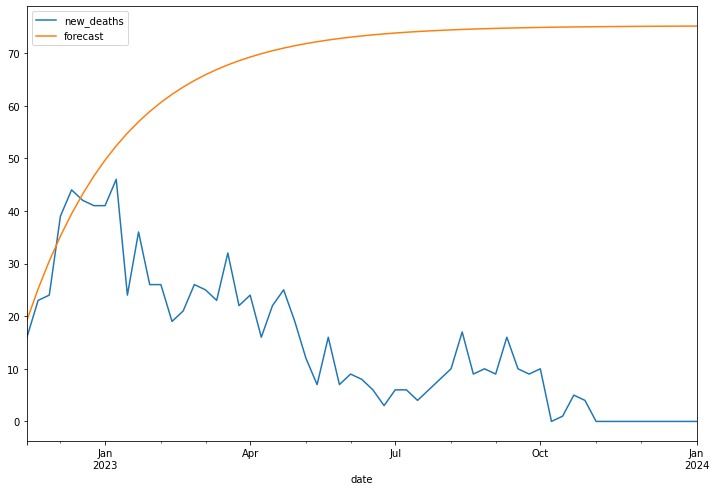

In [60]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [61]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [62]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(israel_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
6,2,3,1305.144435
2,1,3,1305.688010
8,3,1,1305.969429
3,1,4,1306.473602
7,2,4,1306.569677
10,3,3,1306.617848
4,2,1,1306.618400
13,4,2,1307.085652
14,4,3,1307.208637
5,2,2,1307.296196


In [63]:
model=ARIMA(israel_train['new_deaths'],order=(2,0,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -645.572
Date:                Thu, 22 Feb 2024   AIC                           1305.144
Time:                        16:18:31   BIC                           1325.786
Sample:                    03-01-2020   HQIC                          1313.532
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.1699     34.572      2.319      0.020      12.410     147.930
ar.L1          1.2149      0.239      5.084      0.000       0.747       1.683
ar.L2         -0.3983      0.229     -1.737      0.082      -0.848       0.051
ma.L1          0.4035      0.285      1.418      0.156      -0.154       0.961
ma.L2          0.3556      0.181      1.960      0.050   -7.02e-05       0.711
ma.L3          0.2677      0.168      1.592      0.111      -0.062       0.597
sigma2       541.1029     38.633     14.006      0.000     465.384     616.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               430.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

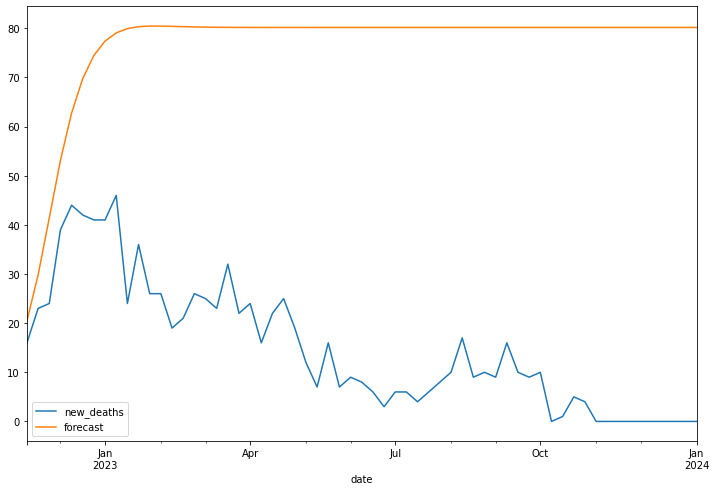

In [64]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [65]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [66]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76589D+00    |proj g|=  1.57929D-01

At iterate    5    f=  4.72387D+00    |proj g|=  4.61198D-03

At iterate   10    f=  4.71609D+00    |proj g|=  4.36637D-02


 This problem is unconstrained.



At iterate   15    f=  4.71358D+00    |proj g|=  1.59955D-02

At iterate   20    f=  4.71156D+00    |proj g|=  2.61649D-03

At iterate   25    f=  4.71135D+00    |proj g|=  4.26528D-03

At iterate   30    f=  4.71127D+00    |proj g|=  2.43383D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   3.509D-05   4.711D+00
  F =   4.7112694277447487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14046D+00    |proj g|=  4.28445D-01

At iterate    5    f=  4.97820D+00    |proj g|=  1.10308D-02

At iterate   10    f=  4.97504D+00    |proj g|=  3.45828D-02

At iterate   15    f=  4.97316D+00    |proj g|=  3.39977D-03

At iterate   20    f=  4.75776D+00    |proj g|=  1.35811D-01

At iterate   25    f=  4.73441D+00    |proj g|=  1.42768D-02

At iterate   30    f=  4.71959D+00    |proj g|=  6.97840D-03

At iterate   35    f=  4.71028D+00    |proj g|=  1.62931D-02

At iterate   40    f=  4.71010D+00    |proj g|=  1.69076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  4.71772D+00    |proj g|=  8.25174D-03

At iterate   10    f=  4.71082D+00    |proj g|=  8.28731D-03

At iterate   15    f=  4.71058D+00    |proj g|=  5.77847D-03

At iterate   20    f=  4.71041D+00    |proj g|=  5.38375D-03

At iterate   25    f=  4.71016D+00    |proj g|=  1.84400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   2.399D-05   4.710D+00
  F =   4.7101621267300136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  4.71784D+00    |proj g|=  5.16550D-03

At iterate   10    f=  4.71501D+00    |proj g|=  4.92622D-02

At iterate   15    f=  4.71079D+00    |proj g|=  2.33982D-03

At iterate   20    f=  4.71058D+00    |proj g|=  4.41054D-03

At iterate   25    f=  4.71030D+00    |proj g|=  8.05797D-03

At iterate   30    f=  4.71005D+00    |proj g|=  3.81709D-04

At iterate   35    f=  4.71002D+00    |proj g|=  1.10976D-03

At iterate   40    f=  4.71002D+00    |proj g|=  4.48330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     46      1     0     0   4.483D-05   4.710D+00
  F =   4.71001914884

 This problem is unconstrained.



At iterate   10    f=  4.67353D+00    |proj g|=  3.16979D-03

At iterate   15    f=  4.66941D+00    |proj g|=  1.09218D-02

At iterate   20    f=  4.66874D+00    |proj g|=  1.72778D-03

At iterate   25    f=  4.66821D+00    |proj g|=  7.25438D-03

At iterate   30    f=  4.66799D+00    |proj g|=  3.75324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     39      1     0     0   1.783D-05   4.668D+00
  F =   4.6679908469789799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09857D+00    |proj g|=  4.69896D-01

At iterate    5    f=  4.95516D+00    |proj g|=  7.70013D-03

At iterate   10    f=  4.95262D+00    |proj g|=  2.35511D-02

At iterate   15    f=  4.94260D+00    |proj g|=  2.46366D-02
  ys=-5.983E-02  -gs= 1.426E-02 BFGS update SKIPPED

At iterate   20    f=  4.73736D+00    |proj g|=  1.06117D-01

At iterate   25    f=  4.68254D+00    |proj g|=  8.13933D-03

At iterate   30    f=  4.67235D+00    |proj g|=  3.40052D-02

At iterate   35    f=  4.66835D+00    |proj g|=  1.06927D-03

At iterate   40    f=  4.66833D+00    |proj g|=  4.00045D-03

At iterate   45    f=  4.66821D+00    |proj g|=  3.83718D-03

At iterate   50    f=  4.66803D+00    |proj g|=  1.12523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  4.67193D+00    |proj g|=  1.40959D-02

At iterate   10    f=  4.67075D+00    |proj g|=  9.20817D-03

At iterate   15    f=  4.66882D+00    |proj g|=  2.01427D-02

At iterate   20    f=  4.66820D+00    |proj g|=  3.99331D-04

At iterate   25    f=  4.66819D+00    |proj g|=  1.60977D-03

At iterate   30    f=  4.66808D+00    |proj g|=  3.27652D-03

At iterate   35    f=  4.66800D+00    |proj g|=  4.61897D-04

At iterate   40    f=  4.66799D+00    |proj g|=  2.28858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     51      1     0     0   5.184D-05   4.668D+00
  F =   4.66798676757

 This problem is unconstrained.



At iterate    5    f=  4.67293D+00    |proj g|=  1.51794D-02

At iterate   10    f=  4.67095D+00    |proj g|=  9.58598D-03

At iterate   15    f=  4.66994D+00    |proj g|=  6.89279D-03

At iterate   20    f=  4.66805D+00    |proj g|=  4.65770D-03

At iterate   25    f=  4.66800D+00    |proj g|=  2.06247D-03

At iterate   30    f=  4.66791D+00    |proj g|=  1.63996D-03

At iterate   35    f=  4.66790D+00    |proj g|=  1.31793D-04

At iterate   40    f=  4.66790D+00    |proj g|=  4.54047D-04

At iterate   45    f=  4.66789D+00    |proj g|=  2.86371D-04

At iterate   50    f=  4.66789D+00    |proj g|=  1.58104D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  4.63517D+00    |proj g|=  2.52864D-03

At iterate   20    f=  4.63299D+00    |proj g|=  3.31934D-03

At iterate   25    f=  4.63288D+00    |proj g|=  3.57783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   6.557D-06   4.633D+00
  F =   4.6328794948970184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02538D+00    |proj g|=  3.77162D-01


 This problem is unconstrained.



At iterate   10    f=  4.94008D+00    |proj g|=  1.30366D-02

At iterate   15    f=  4.92884D+00    |proj g|=  9.24560D-03

At iterate   20    f=  4.70183D+00    |proj g|=  2.02404D-01

At iterate   25    f=  4.63206D+00    |proj g|=  1.19817D-02

At iterate   30    f=  4.63171D+00    |proj g|=  2.74415D-03

At iterate   35    f=  4.63166D+00    |proj g|=  3.21450D-03

At iterate   40    f=  4.63158D+00    |proj g|=  2.04462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     55      1     0     0   3.405D-05   4.632D+00
  F =   4.6315754027979237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.63196D+00    |proj g|=  1.96784D-03

At iterate   10    f=  4.63176D+00    |proj g|=  1.35326D-03

At iterate   15    f=  4.63151D+00    |proj g|=  1.35649D-03

At iterate   20    f=  4.63150D+00    |proj g|=  1.79835D-03

At iterate   25    f=  4.63146D+00    |proj g|=  2.78873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     32      1     0     0   2.789D-05   4.631D+00
  F =   4.6314639840733891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  4.63191D+00    |proj g|=  4.06617D-03

At iterate   10    f=  4.63168D+00    |proj g|=  7.29564D-03

At iterate   15    f=  4.63136D+00    |proj g|=  7.78007D-03

At iterate   20    f=  4.63128D+00    |proj g|=  2.04388D-04

At iterate   25    f=  4.63127D+00    |proj g|=  2.01862D-03

At iterate   30    f=  4.63126D+00    |proj g|=  1.16344D-04

At iterate   35    f=  4.63126D+00    |proj g|=  2.76888D-04

At iterate   40    f=  4.63126D+00    |proj g|=  2.99058D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     44      1     0     0   4.735D-05   4.631D+00
  F =   4.63125980754

 This problem is unconstrained.



At iterate    5    f=  4.62846D+00    |proj g|=  2.79580D-03

At iterate   10    f=  4.62761D+00    |proj g|=  3.70468D-03

At iterate   15    f=  4.62721D+00    |proj g|=  1.31550D-03

At iterate   20    f=  4.62673D+00    |proj g|=  1.44669D-02

At iterate   25    f=  4.62551D+00    |proj g|=  1.66684D-03

At iterate   30    f=  4.62551D+00    |proj g|=  1.19917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     33      1     0     0   1.199D-05   4.626D+00
  F =   4.6255118836483859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01132D+00    |proj g|=  3.42685D-01

At iterate    5    f=  4.95019D+00    |proj g|=  1.21450D-02

At iterate   10    f=  4.94013D+00    |proj g|=  1.12334D-02

At iterate   15    f=  4.93319D+00    |proj g|=  8.15251D-02

At iterate   20    f=  4.92786D+00    |proj g|=  4.75013D-03
  ys=-1.254E-03  -gs= 1.369E-02 BFGS update SKIPPED

At iterate   25    f=  4.73247D+00    |proj g|=  6.36421D-02

At iterate   30    f=  4.65059D+00    |proj g|=  1.73542D-01

At iterate   35    f=  4.62500D+00    |proj g|=  7.10666D-03

At iterate   40    f=  4.62494D+00    |proj g|=  1.70514D-04

At iterate   45    f=  4.62494D+00    |proj g|=  3.39964D-04

At iterate   50    f=  4.62494D+00    |proj g|=  1.38126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  4.62619D+00    |proj g|=  7.38122D-03

At iterate   10    f=  4.62589D+00    |proj g|=  7.95768D-03

At iterate   15    f=  4.62542D+00    |proj g|=  3.05948D-03

At iterate   20    f=  4.62494D+00    |proj g|=  3.25794D-03

At iterate   25    f=  4.62492D+00    |proj g|=  7.51144D-04

At iterate   30    f=  4.62488D+00    |proj g|=  1.57861D-03

At iterate   35    f=  4.62487D+00    |proj g|=  2.01853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     43      1     0     0   9.775D-05   4.625D+00
  F =   4.6248701815718798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.62603D+00    |proj g|=  2.59460D-03

At iterate   10    f=  4.62539D+00    |proj g|=  7.68280D-03

At iterate   15    f=  4.62472D+00    |proj g|=  4.06372D-03

At iterate   20    f=  4.62469D+00    |proj g|=  2.99307D-04

At iterate   25    f=  4.62468D+00    |proj g|=  4.90796D-04

At iterate   30    f=  4.62468D+00    |proj g|=  1.90231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     36      1     0     0   4.205D-05   4.625D+00
  F =   4.6246778430000592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [67]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1318.394351
8,2,1,1,1,1318.472018
10,2,1,2,1,1320.072844
9,2,1,1,2,1320.104264
14,2,2,2,1,1320.213391
13,2,2,1,2,1320.232079
11,2,1,2,2,1322.015266
15,2,2,2,2,1322.159152
4,1,2,1,1,1328.373419
6,1,2,2,1,1330.372268


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63797D+00    |proj g|=  1.30351D-01

At iterate    5    f=  4.62846D+00    |proj g|=  2.79580D-03



At iterate   10    f=  4.62761D+00    |proj g|=  3.70468D-03

At iterate   15    f=  4.62721D+00    |proj g|=  1.31550D-03

At iterate   20    f=  4.62673D+00    |proj g|=  1.44669D-02

At iterate   25    f=  4.62551D+00    |proj g|=  1.66684D-03

At iterate   30    f=  4.62551D+00    |proj g|=  1.19917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     33      1     0     0   1.199D-05   4.626D+00
  F =   4.6255118836483859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<AxesSubplot:xlabel='date'>

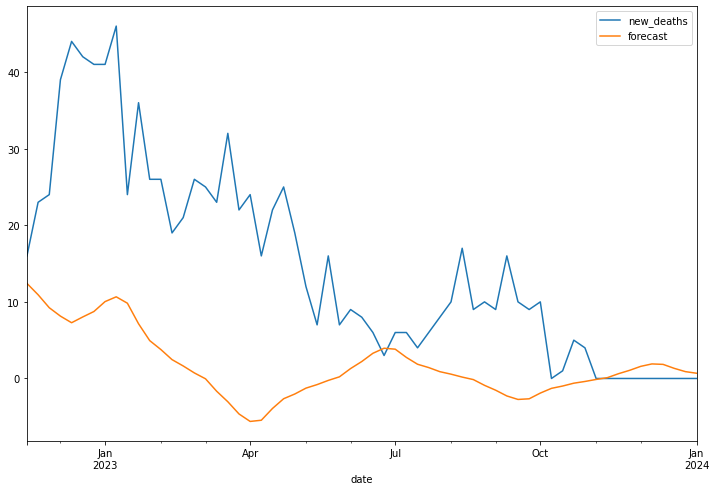

In [68]:
model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(2, 0, 2),seasonal_order=(1,0,1,12))
results=model.fit()
israel_test['forecast']=results.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [69]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
mape = mean_absolute_percentage_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
new_row = {'country': 'Israel', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [70]:
auto_model = auto_arima(israel_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(israel_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -648.339
Date:                Thu, 22 Feb 2024   AIC                           1304.677
Time:                        16:20:36   BIC                           1316.472
Sample:                    03-01-2020   HQIC                          1309.470
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.2294      4.450      2.074      0.038       0.508      17.951
ar.L1          1.5888      0.037     43.221      0.000       1.517       1.661
ar.L2         -0.7015      0.030    -23.265      0.0

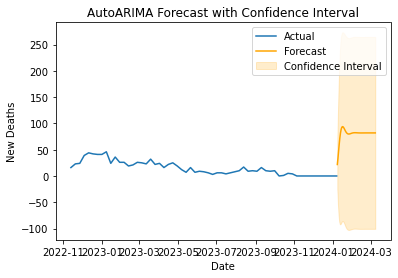

In [71]:
forecast_index = pd.date_range(israel_test.index[-1], periods=n_periods + 1, freq=israel_test.index.freq)[-n_periods:]

plt.plot(israel_test.index, israel_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [72]:
mae = mean_absolute_error(israel_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(israel_test['new_deaths'], forecast)
r2 = r2_score(israel_test['new_deaths'], forecast)
new_row = {'country': 'Israel', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Italy

## train/test split

In [73]:
italy = pd.read_csv('univariate_df_Italy.csv')
italy = italy.set_index('date')
italy.index = pd.to_datetime(italy.index)
italy = italy.drop('Unnamed: 0', axis=1)
italy.sort_index()
train_size = int(len(italy) * 0.7)
italy_train, italy_test = italy[0:train_size], italy[train_size:]
print(italy_train.shape, italy_test.shape)

(141, 1) (61, 1)


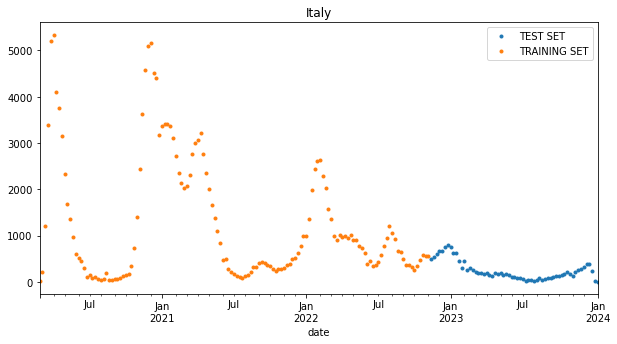

In [74]:
_ = italy_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(italy_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Italy', style='.')

## basic ARIMA (1,0,1)

In [75]:
model=ARIMA(italy_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1014.268
Date:                Thu, 22 Feb 2024   AIC                           2036.536
Time:                        16:22:12   BIC                           2048.331
Sample:                    03-01-2020   HQIC                          2041.329
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1273.9344    793.237      1.606      0.108    -280.782    2828.651
ar.L1          0.9275      0.030     31.330      0.000       0.870       0.986
ma.L1          0.5555      0.042     13.356      0.000       0.474       0.637
sigma2      1.014e+05   6760.309     14.993      0.000    8.81e+04    1.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.67   Jarque-Bera (JB):               370.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

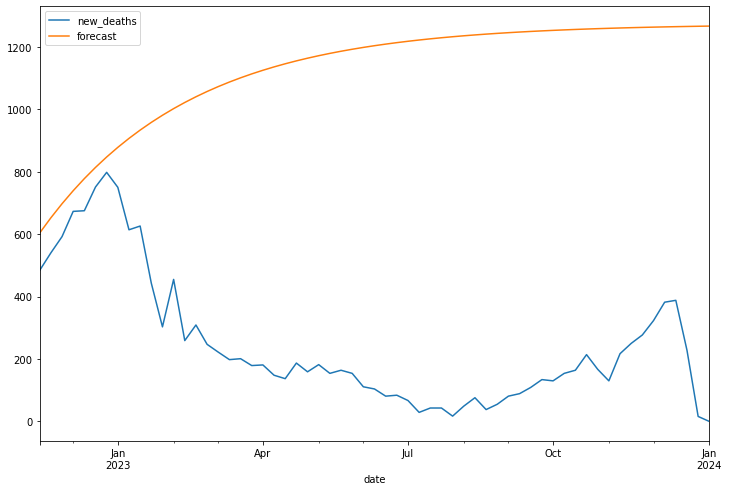

In [76]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [77]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [78]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(italy_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
5,2,2,2005.973554
4,2,1,2005.974262
12,4,1,2007.451429
6,2,3,2007.580354
3,1,4,2007.603956
8,3,1,2008.544875
2,1,3,2009.021812
1,1,2,2009.429377
9,3,2,2009.591650
10,3,3,2009.871849


In [79]:
model=ARIMA(italy_train['new_deaths'],order=(2,0,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -996.987
Date:                Thu, 22 Feb 2024   AIC                           2005.974
Time:                        16:22:50   BIC                           2023.666
Sample:                    03-01-2020   HQIC                          2013.163
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1274.0376    552.024      2.308      0.021     192.091    2355.984
ar.L1          1.4091      0.088     16.061      0.000       1.237       1.581
ar.L2         -0.5066      0.084     -6.003      0.000      -0.672      -0.341
ma.L1          0.2702      0.101      2.677      0.007       0.072       0.468
ma.L2          0.1867      0.078      2.384      0.017       0.033       0.340
sigma2      7.898e+04   5732.751     13.776      0.000    6.77e+04    9.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               351.82
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

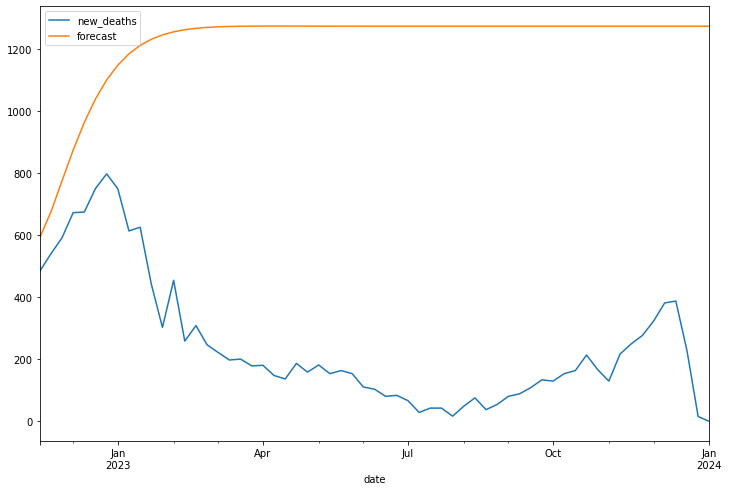

In [80]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [81]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [82]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45453D+00    |proj g|=  4.62526D-01

At iterate    5    f=  7.19498D+00    |proj g|=  1.98767D-02


 This problem is unconstrained.



At iterate   10    f=  7.19271D+00    |proj g|=  3.81378D-03

At iterate   15    f=  7.19192D+00    |proj g|=  3.80099D-04

At iterate   20    f=  7.19188D+00    |proj g|=  3.07183D-03

At iterate   25    f=  7.18991D+00    |proj g|=  2.52813D-03

At iterate   30    f=  7.18904D+00    |proj g|=  8.49493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     37      1     0     0   5.275D-06   7.189D+00
  F =   7.1890371455022324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44221D+00    |proj g|=  4.44330D-01

At iterate    5    f=  7.19167D+00    |proj g|=  8.25078D-03

At iterate   10    f=  7.18856D+00    |proj g|=  1.36678D-03

At iterate   15    f=  7.18843D+00    |proj g|=  4.32295D-04

At iterate   20    f=  7.18833D+00    |proj g|=  5.65704D-03

At iterate   25    f=  7.18616D+00    |proj g|=  6.86692D-03

At iterate   30    f=  7.18603D+00    |proj g|=  9.02959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.19218D+00    |proj g|=  8.19916D-03

At iterate   10    f=  7.18919D+00    |proj g|=  1.68352D-02

At iterate   15    f=  7.18845D+00    |proj g|=  3.18292D-03

At iterate   20    f=  7.18842D+00    |proj g|=  7.50225D-04

At iterate   25    f=  7.18817D+00    |proj g|=  7.89895D-03

At iterate   30    f=  7.18755D+00    |proj g|=  1.55342D-03

At iterate   35    f=  7.18665D+00    |proj g|=  1.24097D-02

At iterate   40    f=  7.18606D+00    |proj g|=  5.96341D-04

At iterate   45    f=  7.18604D+00    |proj g|=  3.32037D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     50   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42564D+00    |proj g|=  3.64448D-01

At iterate    5    f=  7.19148D+00    |proj g|=  1.36534D-02

At iterate   10    f=  7.18854D+00    |proj g|=  2.07557D-02

At iterate   15    f=  7.18740D+00    |proj g|=  5.17645D-04

At iterate   20    f=  7.18734D+00    |proj g|=  2.74021D-03

At iterate   25    f=  7.18733D+00    |proj g|=  5.11669D-04

At iterate   30    f=  7.18728D+00    |proj g|=  1.63841D-03

At iterate   35    f=  7.18690D+00    |proj g|=  4.62782D-03

At iterate   40    f=  7.18524D+00    |proj g|=  9.21843D-03

At iterate   45    f=  7.18506D+00    |proj g|=  5.59434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  7.14831D+00    |proj g|=  2.00117D-02

At iterate   10    f=  7.13500D+00    |proj g|=  4.46468D-03

At iterate   15    f=  7.13401D+00    |proj g|=  2.05328D-02

At iterate   20    f=  7.13304D+00    |proj g|=  6.87994D-03

At iterate   25    f=  7.10046D+00    |proj g|=  2.02208D-02

At iterate   30    f=  7.09977D+00    |proj g|=  5.35075D-03

At iterate   35    f=  7.09864D+00    |proj g|=  5.57664D-03

At iterate   40    f=  7.09841D+00    |proj g|=  7.01100D-04

At iterate   45    f=  7.09838D+00    |proj g|=  1.87204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     56   

 This problem is unconstrained.



At iterate   10    f=  7.13021D+00    |proj g|=  6.92790D-03

At iterate   15    f=  7.12969D+00    |proj g|=  3.84114D-03

At iterate   20    f=  7.12864D+00    |proj g|=  1.14175D-02

At iterate   25    f=  7.11888D+00    |proj g|=  9.44216D-02

At iterate   30    f=  7.09986D+00    |proj g|=  9.69991D-03

At iterate   35    f=  7.09962D+00    |proj g|=  1.72686D-03

At iterate   40    f=  7.09958D+00    |proj g|=  3.71733D-03

At iterate   45    f=  7.09517D+00    |proj g|=  7.24570D-02

At iterate   50    f=  7.08439D+00    |proj g|=  1.82491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70   

 This problem is unconstrained.



At iterate   10    f=  7.12782D+00    |proj g|=  4.88036D-03

At iterate   15    f=  7.12725D+00    |proj g|=  9.77589D-03

At iterate   20    f=  7.12698D+00    |proj g|=  6.68576D-03

At iterate   25    f=  7.11832D+00    |proj g|=  1.04831D-01

At iterate   30    f=  7.09455D+00    |proj g|=  1.92841D-02

At iterate   35    f=  7.09350D+00    |proj g|=  1.48965D-03

At iterate   40    f=  7.09323D+00    |proj g|=  1.00151D-02

At iterate   45    f=  7.08422D+00    |proj g|=  1.64011D-02

At iterate   50    f=  7.08278D+00    |proj g|=  5.54004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36144D+00    |proj g|=  4.32154D-01

At iterate    5    f=  7.14281D+00    |proj g|=  2.55030D-02

At iterate   10    f=  7.13207D+00    |proj g|=  1.12005D-02

At iterate   15    f=  7.12138D+00    |proj g|=  5.70573D-02

At iterate   20    f=  7.09665D+00    |proj g|=  3.63217D-02

At iterate   25    f=  7.08830D+00    |proj g|=  1.04989D-02

At iterate   30    f=  7.08423D+00    |proj g|=  1.21597D-02

At iterate   35    f=  7.08233D+00    |proj g|=  1.57667D-02

At iterate   40    f=  7.07630D+00    |proj g|=  1.52549D-02

At iterate   45    f=  7.06812D+00    |proj g|=  4.09468D-03

At iterate   50    f=  7.06796D+00    |proj g|=  3.32401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.12219D+00    |proj g|=  8.72616D-03

At iterate   10    f=  7.11842D+00    |proj g|=  2.51507D-02

At iterate   15    f=  7.11761D+00    |proj g|=  4.15324D-03

At iterate   20    f=  7.11738D+00    |proj g|=  1.77052D-03

At iterate   25    f=  7.11549D+00    |proj g|=  2.58049D-02

At iterate   30    f=  7.10300D+00    |proj g|=  6.52951D-03

At iterate   35    f=  7.10065D+00    |proj g|=  8.82578D-03

At iterate   40    f=  7.10023D+00    |proj g|=  4.17386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     47      1     0     0   1.816D-05   7.100D+00
  F =   7.10023134829

 This problem is unconstrained.



At iterate    5    f=  7.11821D+00    |proj g|=  1.13854D-02

At iterate   10    f=  7.11518D+00    |proj g|=  1.70430D-02

At iterate   15    f=  7.11476D+00    |proj g|=  3.92496D-03

At iterate   20    f=  7.11456D+00    |proj g|=  1.69653D-03

At iterate   25    f=  7.11291D+00    |proj g|=  2.16162D-02

At iterate   30    f=  7.10436D+00    |proj g|=  1.40155D-02

At iterate   35    f=  7.09842D+00    |proj g|=  5.36225D-03

At iterate   40    f=  7.09826D+00    |proj g|=  1.25376D-03

At iterate   45    f=  7.09823D+00    |proj g|=  3.15143D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     50   

 This problem is unconstrained.



At iterate   10    f=  7.11492D+00    |proj g|=  1.53652D-02

At iterate   15    f=  7.11343D+00    |proj g|=  5.68826D-03

At iterate   20    f=  7.11333D+00    |proj g|=  2.39495D-03

At iterate   25    f=  7.11029D+00    |proj g|=  4.22095D-02

At iterate   30    f=  7.10200D+00    |proj g|=  4.86194D-03

At iterate   35    f=  7.10005D+00    |proj g|=  9.53201D-03

At iterate   40    f=  7.09750D+00    |proj g|=  7.47619D-03

At iterate   45    f=  7.09744D+00    |proj g|=  1.11493D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     51      1     0     0   1.115D-05   7.097D+00
  F =   7.09743643289

 This problem is unconstrained.



At iterate    5    f=  7.11837D+00    |proj g|=  1.13686D-02

At iterate   10    f=  7.11433D+00    |proj g|=  1.89245D-02

At iterate   15    f=  7.09934D+00    |proj g|=  3.16002D-02

At iterate   20    f=  7.09490D+00    |proj g|=  5.81887D-03

At iterate   25    f=  7.08976D+00    |proj g|=  1.94724D-02

At iterate   30    f=  7.08571D+00    |proj g|=  2.08056D-02

At iterate   35    f=  7.08522D+00    |proj g|=  2.09075D-03

At iterate   40    f=  7.08488D+00    |proj g|=  5.80881D-03

At iterate   45    f=  7.08364D+00    |proj g|=  5.05550D-03

At iterate   50    f=  7.08276D+00    |proj g|=  4.27745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20343D+00    |proj g|=  7.46232D-02

At iterate   10    f=  7.18845D+00    |proj g|=  3.27983D-02

At iterate   15    f=  7.18438D+00    |proj g|=  1.40435D-02

At iterate   20    f=  7.17326D+00    |proj g|=  6.04298D-02

At iterate   25    f=  7.09954D+00    |proj g|=  1.81090D-02

At iterate   30    f=  7.09576D+00    |proj g|=  4.72324D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   2.057D-05   7.096D+00
  F =   7.0957553953047823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  7.19080D+00    |proj g|=  8.65111D-02

At iterate   10    f=  7.18112D+00    |proj g|=  1.13825D-02

At iterate   15    f=  7.17861D+00    |proj g|=  4.16747D-03

At iterate   20    f=  7.17379D+00    |proj g|=  4.96404D-02

At iterate   25    f=  7.11141D+00    |proj g|=  9.00082D-02

At iterate   30    f=  7.09454D+00    |proj g|=  7.72845D-04

At iterate   35    f=  7.09453D+00    |proj g|=  1.41506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     44      1     0     0   1.415D-05   7.095D+00
  F =   7.0945291800512633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.19597D+00    |proj g|=  3.81330D-02

At iterate   10    f=  7.17977D+00    |proj g|=  1.98260D-02

At iterate   15    f=  7.17594D+00    |proj g|=  4.61368D-03

At iterate   20    f=  7.17330D+00    |proj g|=  1.07037D-02

At iterate   25    f=  7.16112D+00    |proj g|=  4.23076D-02

At iterate   30    f=  7.09533D+00    |proj g|=  2.85460D-02

At iterate   35    f=  7.09433D+00    |proj g|=  8.38593D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     40      1     0     0   2.315D-05   7.094D+00
  F =   7.0943347645784165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.19228D+00    |proj g|=  1.44358D-01

At iterate   10    f=  7.18172D+00    |proj g|=  1.15055D-02

At iterate   15    f=  7.17470D+00    |proj g|=  5.11047D-02

At iterate   20    f=  7.16228D+00    |proj g|=  5.59248D-02

At iterate   25    f=  7.12268D+00    |proj g|=  3.64452D-02

At iterate   30    f=  7.11473D+00    |proj g|=  1.16599D-02

At iterate   35    f=  7.10280D+00    |proj g|=  7.80969D-03

At iterate   40    f=  7.09567D+00    |proj g|=  1.11927D-02

At iterate   45    f=  7.08456D+00    |proj g|=  3.55157D-02

At iterate   50    f=  7.08118D+00    |proj g|=  1.60223D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [83]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
7,1,2,2,2,2009.165987
6,1,2,2,1,2011.344057
5,1,2,1,2,2011.797661
11,2,1,2,2,2013.337041
4,1,2,1,1,2013.743394
8,2,1,1,1,2014.265240
15,2,2,2,2,2014.892628
12,2,2,1,1,2015.003021
10,2,1,2,1,2015.477074
9,2,1,1,2,2015.700773


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36144D+00    |proj g|=  4.32154D-01


 This problem is unconstrained.



At iterate    5    f=  7.14281D+00    |proj g|=  2.55030D-02

At iterate   10    f=  7.13207D+00    |proj g|=  1.12005D-02

At iterate   15    f=  7.12138D+00    |proj g|=  5.70573D-02

At iterate   20    f=  7.09665D+00    |proj g|=  3.63217D-02

At iterate   25    f=  7.08830D+00    |proj g|=  1.04989D-02

At iterate   30    f=  7.08423D+00    |proj g|=  1.21597D-02

At iterate   35    f=  7.08233D+00    |proj g|=  1.57667D-02

At iterate   40    f=  7.07630D+00    |proj g|=  1.52549D-02

At iterate   45    f=  7.06812D+00    |proj g|=  4.09468D-03

At iterate   50    f=  7.06796D+00    |proj g|=  3.32401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot:xlabel='date'>

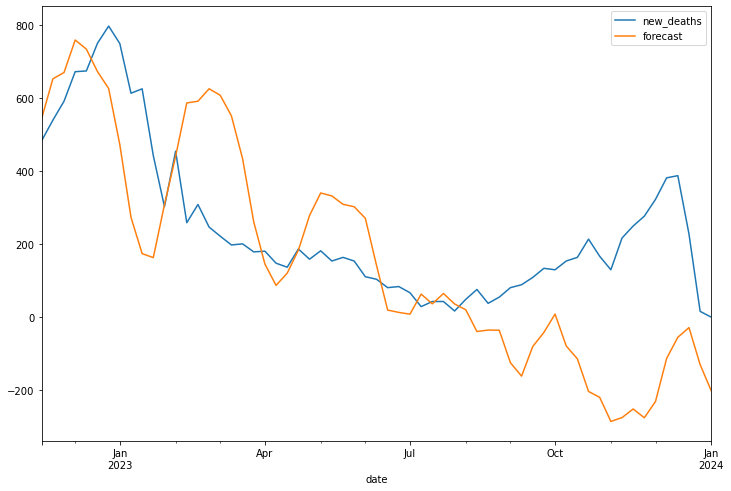

In [84]:
model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(1, 0, 2),seasonal_order=(2,0,2,12))
results=model.fit()
italy_test['forecast']=results.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [85]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
mape = mean_absolute_percentage_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
new_row = {'country': 'Italy', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [86]:
auto_model = auto_arima(italy_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(italy_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  141
Model:             SARIMAX(3, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -993.435
Date:                                 Thu, 22 Feb 2024   AIC                           2004.871
Time:                                         16:24:47   BIC                           2031.410
Sample:                                     03-01-2020   HQIC                          2015.655
                                          - 11-06-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.7997     26.332      1.322      0.186     -16.809      86

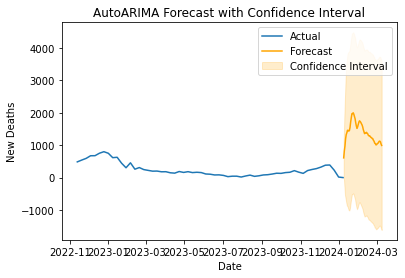

In [87]:
forecast_index = pd.date_range(italy_test.index[-1], periods=n_periods + 1, freq=italy_test.index.freq)[-n_periods:]

plt.plot(italy_test.index, italy_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [88]:
mae = mean_absolute_error(italy_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(italy_test['new_deaths'], forecast)
r2 = r2_score(italy_test['new_deaths'], forecast)
new_row = {'country': 'Italy', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# United States

## train/test split

In [91]:
us = pd.read_csv('univariate_df_United_States.csv')
us = us.set_index('date')
us.index = pd.to_datetime(us.index)
us = us.drop('Unnamed: 0', axis=1)
us = us.drop('diff1', axis=1)
us.sort_index()
train_size = int(len(us) * 0.7)
us_train, us_test = us[0:train_size], us[train_size:]
print(us_train.shape, us_test.shape)

(141, 1) (61, 1)


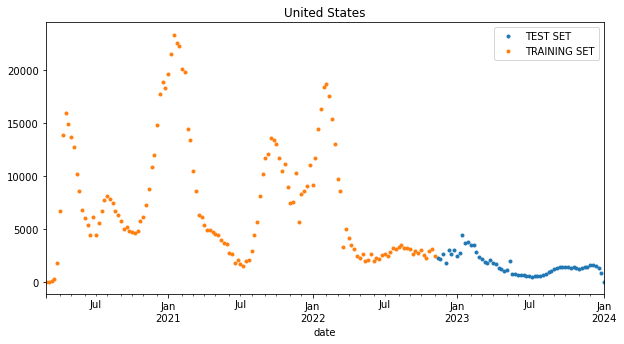

In [92]:
_ = us_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(us_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='United States', style='.')

## basic ARIMA (1,1,1)

In [93]:
model=ARIMA(us_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1217.761
Date:                Thu, 22 Feb 2024   AIC                           2441.522
Time:                        16:28:38   BIC                           2450.347
Sample:                    03-01-2020   HQIC                          2445.108
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7216      0.107      6.717      0.000       0.511       0.932
ma.L1         -0.3930      0.129     -3.046      0.002      -0.646      -0.140
sigma2      2.167e+06   1.63e+05     13.286      0.000    1.85e+06    2.49e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                78.03
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.07
Prob(H) (two-sided):                  0.33   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

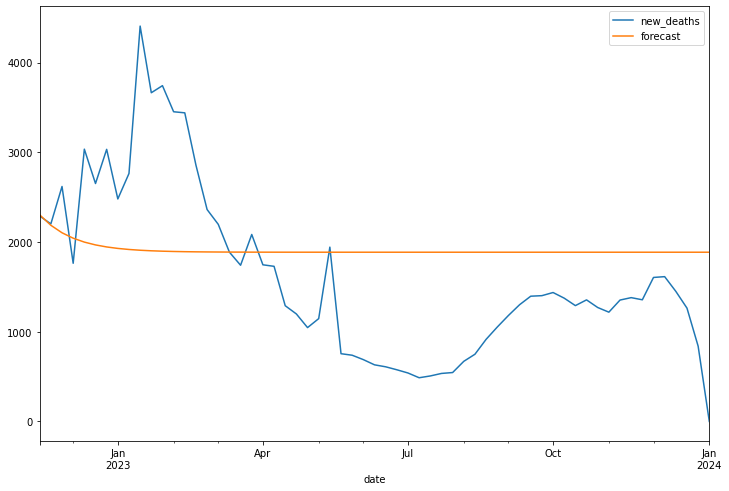

In [94]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [95]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [96]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(us_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
8,3,1,2430.672250
9,3,2,2431.981093
12,4,1,2432.044905
10,3,3,2433.653184
7,2,4,2433.781745
13,4,2,2434.676250
6,2,3,2436.275722
5,2,2,2436.461457
1,1,2,2436.975261
4,2,1,2437.961302


In [97]:
model=ARIMA(us_train['new_deaths'],order=(3,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1210.336
Date:                Thu, 22 Feb 2024   AIC                           2430.672
Time:                        16:29:06   BIC                           2445.380
Sample:                    03-01-2020   HQIC                          2436.649
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2003      0.046     26.272      0.000       1.111       1.290
ar.L2          0.0869      0.081      1.080      0.280      -0.071       0.245
ar.L3         -0.3600      0.053     -6.773      0.000      -0.464      -0.256
ma.L1         -1.0000      0.078    -12.743      0.000      -1.154      -0.846
sigma2      1.853e+06   4.24e-08   4.37e+13      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                66.86
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.20
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

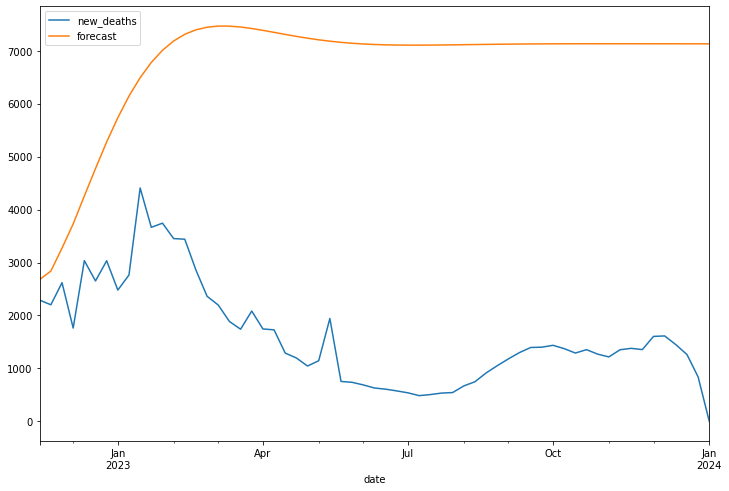

In [98]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [99]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [101]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06061D+00    |proj g|=  5.07809D-02

At iterate    5    f=  8.03418D+00    |proj g|=  4.47411D-03


 This problem is unconstrained.



At iterate   10    f=  8.03358D+00    |proj g|=  2.23520D-04

At iterate   15    f=  8.03350D+00    |proj g|=  3.90973D-03

At iterate   20    f=  8.01456D+00    |proj g|=  9.27458D-02

At iterate   25    f=  7.95917D+00    |proj g|=  2.18038D-02

At iterate   30    f=  7.95860D+00    |proj g|=  3.32023D-03

At iterate   35    f=  7.91797D+00    |proj g|=  8.04967D-03

At iterate   40    f=  7.91792D+00    |proj g|=  5.97034D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     57      1     0     0   5.970D-06   7.918D+00
  F =   7.9179200327490884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.03968D+00    |proj g|=  4.79713D-03

At iterate   10    f=  8.03871D+00    |proj g|=  2.34419D-03

At iterate   15    f=  8.03305D+00    |proj g|=  1.15879D-02

At iterate   20    f=  8.03186D+00    |proj g|=  1.17313D-02

At iterate   25    f=  8.03142D+00    |proj g|=  2.25778D-04

At iterate   30    f=  8.03121D+00    |proj g|=  2.00500D-03

At iterate   35    f=  8.00400D+00    |proj g|=  5.42190D-02

At iterate   40    f=  7.94432D+00    |proj g|=  5.49766D-02

At iterate   45    f=  7.92852D+00    |proj g|=  2.27464D-02

At iterate   50    f=  7.91704D+00    |proj g|=  2.25164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.03380D+00    |proj g|=  4.11864D-02

At iterate   10    f=  8.02987D+00    |proj g|=  2.20839D-03

At iterate   15    f=  8.02984D+00    |proj g|=  2.45572D-04

At iterate   20    f=  8.02964D+00    |proj g|=  8.71901D-03

At iterate   25    f=  7.97473D+00    |proj g|=  8.33588D-02

At iterate   30    f=  7.94791D+00    |proj g|=  3.38808D-03

At iterate   35    f=  7.92204D+00    |proj g|=  1.37587D-01

At iterate   40    f=  7.91154D+00    |proj g|=  5.26656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     59      1     0     0   8.857D-05   7.912D+00
  F =   7.91153652645

 This problem is unconstrained.



At iterate    5    f=  8.02866D+00    |proj g|=  5.67345D-03

At iterate   10    f=  8.02771D+00    |proj g|=  3.10144D-04

At iterate   15    f=  8.02768D+00    |proj g|=  2.98530D-04

At iterate   20    f=  8.02766D+00    |proj g|=  1.64054D-03

At iterate   25    f=  8.02603D+00    |proj g|=  1.73275D-02

At iterate   30    f=  7.96301D+00    |proj g|=  1.07542D-01

At iterate   35    f=  7.91944D+00    |proj g|=  5.19779D-03

At iterate   40    f=  7.91917D+00    |proj g|=  4.61847D-03

At iterate   45    f=  7.91720D+00    |proj g|=  3.38601D-03

At iterate   50    f=  7.91643D+00    |proj g|=  1.26676D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.94709D+00    |proj g|=  1.54849D-03

At iterate   10    f=  7.94707D+00    |proj g|=  2.10221D-04

At iterate   15    f=  7.94701D+00    |proj g|=  5.13474D-03

At iterate   20    f=  7.93337D+00    |proj g|=  5.54073D-02

At iterate   25    f=  7.88091D+00    |proj g|=  1.44732D-02

At iterate   30    f=  7.87864D+00    |proj g|=  1.39638D-02

At iterate   35    f=  7.87818D+00    |proj g|=  2.21400D-03

At iterate   40    f=  7.87813D+00    |proj g|=  4.57218D-04

At iterate   45    f=  7.87812D+00    |proj g|=  4.25795D-04

At iterate   50    f=  7.87812D+00    |proj g|=  9.58972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04274D+00    |proj g|=  2.89750D-01

At iterate    5    f=  7.95285D+00    |proj g|=  2.98375D-03

At iterate   10    f=  7.95231D+00    |proj g|=  7.59444D-03

At iterate   15    f=  7.94934D+00    |proj g|=  1.56624D-02

At iterate   20    f=  7.94466D+00    |proj g|=  8.22057D-03

At iterate   25    f=  7.94451D+00    |proj g|=  2.98752D-04

At iterate   30    f=  7.94443D+00    |proj g|=  6.08512D-03

At iterate   35    f=  7.90370D+00    |proj g|=  4.97405D-02

At iterate   40    f=  7.88839D+00    |proj g|=  7.50712D-03

At iterate   45    f=  7.88815D+00    |proj g|=  1.16747D-02

At iterate   50    f=  7.88536D+00    |proj g|=  7.36862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.94965D+00    |proj g|=  7.16399D-02

At iterate   10    f=  7.94372D+00    |proj g|=  7.16841D-04

At iterate   15    f=  7.94371D+00    |proj g|=  2.14295D-04

At iterate   20    f=  7.94365D+00    |proj g|=  2.24450D-03

At iterate   25    f=  7.93485D+00    |proj g|=  8.01178D-02

At iterate   30    f=  7.90918D+00    |proj g|=  3.43782D-02

At iterate   35    f=  7.88173D+00    |proj g|=  7.36101D-02

At iterate   40    f=  7.87397D+00    |proj g|=  6.98237D-03

At iterate   45    f=  7.87283D+00    |proj g|=  7.61692D-04

At iterate   50    f=  7.87270D+00    |proj g|=  1.75081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.94247D+00    |proj g|=  6.68846D-04

At iterate   10    f=  7.94245D+00    |proj g|=  1.30044D-03

At iterate   15    f=  7.94239D+00    |proj g|=  2.16250D-04

At iterate   20    f=  7.94233D+00    |proj g|=  3.01735D-03

At iterate   25    f=  7.93743D+00    |proj g|=  2.41317D-02

At iterate   30    f=  7.88706D+00    |proj g|=  5.50904D-02

At iterate   35    f=  7.87308D+00    |proj g|=  7.92493D-03

At iterate   40    f=  7.87142D+00    |proj g|=  2.54388D-02

At iterate   45    f=  7.87043D+00    |proj g|=  5.84088D-03

At iterate   50    f=  7.86988D+00    |proj g|=  1.98872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.99628D+00    |proj g|=  3.70419D-03

At iterate   10    f=  7.99594D+00    |proj g|=  2.29812D-04

At iterate   15    f=  7.99591D+00    |proj g|=  3.47822D-03

At iterate   20    f=  7.99226D+00    |proj g|=  4.74846D-02

At iterate   25    f=  7.90764D+00    |proj g|=  8.42984D-02

At iterate   30    f=  7.88889D+00    |proj g|=  7.08079D-03

At iterate   35    f=  7.88631D+00    |proj g|=  9.12033D-04

At iterate   40    f=  7.88610D+00    |proj g|=  2.63253D-03

At iterate   45    f=  7.88608D+00    |proj g|=  4.21303D-04

At iterate   50    f=  7.88607D+00    |proj g|=  2.13315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.00143D+00    |proj g|=  5.45283D-03

At iterate   10    f=  8.00065D+00    |proj g|=  2.62775D-03

At iterate   15    f=  7.99535D+00    |proj g|=  1.64483D-02

At iterate   20    f=  7.99427D+00    |proj g|=  4.75066D-04

At iterate   25    f=  7.99424D+00    |proj g|=  1.39251D-03

At iterate   30    f=  7.99230D+00    |proj g|=  5.11295D-02

At iterate   35    f=  7.92067D+00    |proj g|=  1.41226D-01

At iterate   40    f=  7.89327D+00    |proj g|=  3.58295D-02

At iterate   45    f=  7.88554D+00    |proj g|=  8.34464D-03

At iterate   50    f=  7.88507D+00    |proj g|=  7.59011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02167D+00    |proj g|=  6.48751D-02

At iterate    5    f=  7.99467D+00    |proj g|=  1.97586D-02

At iterate   10    f=  7.99344D+00    |proj g|=  1.40685D-03

At iterate   15    f=  7.99341D+00    |proj g|=  2.32376D-04

At iterate   20    f=  7.99335D+00    |proj g|=  5.43847D-03

At iterate   25    f=  7.98451D+00    |proj g|=  7.47645D-02

At iterate   30    f=  7.91389D+00    |proj g|=  3.81544D-02

At iterate   35    f=  7.88222D+00    |proj g|=  2.00405D-02

At iterate   40    f=  7.88195D+00    |proj g|=  1.36737D-03

At iterate   45    f=  7.88180D+00    |proj g|=  3.22910D-03

At iterate   50    f=  7.88175D+00    |proj g|=  1.81676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.99233D+00    |proj g|=  4.85248D-03

At iterate   10    f=  7.99195D+00    |proj g|=  4.77714D-04

At iterate   15    f=  7.99190D+00    |proj g|=  8.87967D-04

At iterate   20    f=  7.99189D+00    |proj g|=  7.98235D-04

At iterate   25    f=  7.99110D+00    |proj g|=  9.27155D-03

At iterate   30    f=  7.90930D+00    |proj g|=  8.07172D-02

At iterate   35    f=  7.88311D+00    |proj g|=  7.23578D-03

At iterate   40    f=  7.88241D+00    |proj g|=  4.16667D-03

At iterate   45    f=  7.87876D+00    |proj g|=  1.35467D-02

At iterate   50    f=  7.87852D+00    |proj g|=  1.67138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.94692D+00    |proj g|=  3.16244D-03

At iterate   10    f=  7.94684D+00    |proj g|=  2.10109D-04

At iterate   15    f=  7.94683D+00    |proj g|=  7.52305D-04

At iterate   20    f=  7.94678D+00    |proj g|=  3.34412D-03

At iterate   25    f=  7.94139D+00    |proj g|=  2.80367D-02

At iterate   30    f=  7.88285D+00    |proj g|=  8.51542D-03

At iterate   35    f=  7.87852D+00    |proj g|=  2.24719D-03

At iterate   40    f=  7.87819D+00    |proj g|=  7.66047D-03

At iterate   45    f=  7.87809D+00    |proj g|=  7.49546D-04

At iterate   50    f=  7.87808D+00    |proj g|=  2.17028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.95247D+00    |proj g|=  1.77415D-03

At iterate   10    f=  7.95198D+00    |proj g|=  1.34357D-02

At iterate   15    f=  7.94495D+00    |proj g|=  1.59143D-02

At iterate   20    f=  7.94453D+00    |proj g|=  1.76037D-03

At iterate   25    f=  7.94426D+00    |proj g|=  2.70952D-04

At iterate   30    f=  7.94426D+00    |proj g|=  4.37408D-04

At iterate   35    f=  7.94340D+00    |proj g|=  1.15953D-02

At iterate   40    f=  7.92099D+00    |proj g|=  6.32821D-02

At iterate   45    f=  7.88926D+00    |proj g|=  3.64223D-02

At iterate   50    f=  7.87551D+00    |proj g|=  6.29471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.94965D+00    |proj g|=  5.93913D-02

At iterate   10    f=  7.94350D+00    |proj g|=  8.86377D-04

At iterate   15    f=  7.94349D+00    |proj g|=  5.51652D-04

At iterate   20    f=  7.94348D+00    |proj g|=  2.14202D-04

At iterate   25    f=  7.94346D+00    |proj g|=  2.88455D-03

At iterate   30    f=  7.94223D+00    |proj g|=  6.33766D-03

At iterate   35    f=  7.91073D+00    |proj g|=  3.40540D-02

At iterate   40    f=  7.89161D+00    |proj g|=  1.17803D-02

At iterate   45    f=  7.88926D+00    |proj g|=  1.28394D-02

At iterate   50    f=  7.87518D+00    |proj g|=  2.65759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94906D+00    |proj g|=  6.18255D-02

At iterate    5    f=  7.94223D+00    |proj g|=  1.64037D-03

At iterate   10    f=  7.94217D+00    |proj g|=  1.86349D-03

At iterate   15    f=  7.94213D+00    |proj g|=  6.18284D-04

At iterate   20    f=  7.94213D+00    |proj g|=  2.16097D-04

At iterate   25    f=  7.94190D+00    |proj g|=  7.40771D-03

At iterate   30    f=  7.93796D+00    |proj g|=  1.26758D-02

At iterate   35    f=  7.91497D+00    |proj g|=  3.21629D-02

At iterate   40    f=  7.90025D+00    |proj g|=  6.03026D-03

At iterate   45    f=  7.89374D+00    |proj g|=  9.01051D-02

At iterate   50    f=  7.88393D+00    |proj g|=  5.29862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [102]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
4,1,2,1,1,2233.629589
6,1,2,2,1,2234.102494
7,1,2,2,2,2235.307282
12,2,2,1,1,2235.618323
8,2,1,1,1,2235.872353
10,2,1,2,1,2236.653998
14,2,2,2,1,2236.801153
13,2,2,1,2,2236.893815
9,2,1,1,2,2237.590092
5,1,2,1,2,2237.671775


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97319D+00    |proj g|=  5.80860D-02

At iterate    5    f=  7.94709D+00    |proj g|=  1.54849D-03

At iterate   10    f=  7.94707D+00    |proj g|=  2.10221D-04

At iterate   15    f=  7.94701D+00    |proj g|=  5.13474D-03

At iterate   20    f=  7.93337D+00    |proj g|=  5.54073D-02

At iterate   25    f=  7.88091D+00    |proj g|=  1.44732D-02

At iterate   30    f=  7.87864D+00    |proj g|=  1.39638D-02

At iterate   35    f=  7.87818D+00    |proj g|=  2.21400D-03

At iterate   40    f=  7.87813D+00    |proj g|=  4.57218D-04

At iterate   45    f=  7.87812D+00    |proj g|=  4.25795D-04

At iterate   50    f=  7.87812D+00    |proj g|=  9.58972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

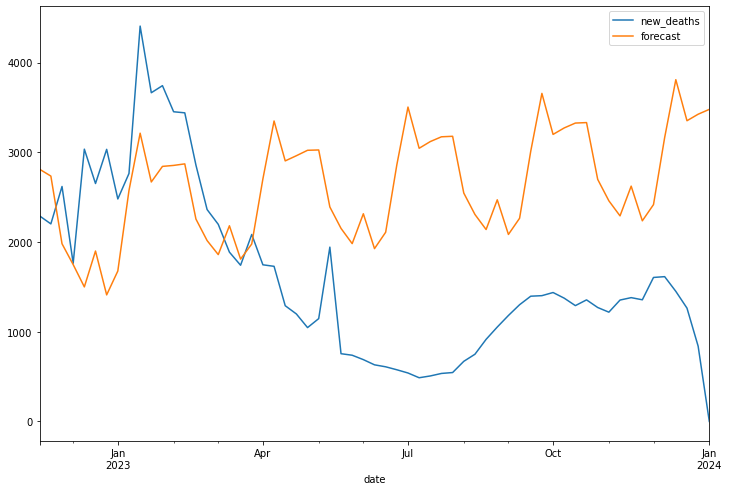

In [103]:
model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(1, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
us_test['forecast']=results.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [104]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
mape = mean_absolute_percentage_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
new_row = {'country': 'US', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [105]:
auto_model = auto_arima(us_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(us_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1218.307
Date:                Thu, 22 Feb 2024   AIC                           2448.615
Time:                        16:32:11   BIC                           2466.308
Sample:                    03-01-2020   HQIC                          2455.805
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    512.5092    157.772      3.248      0.001     203.282     821.737
ar.L1          1.6825      0.092     18.379      0.000       1.503       1.862
ar.L2         -0.7485      0.086     -8.746      0.0

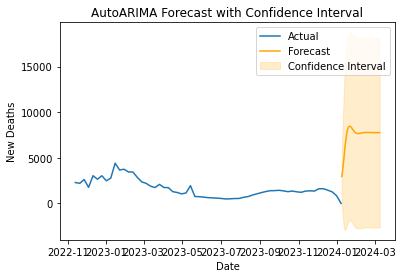

In [106]:
forecast_index = pd.date_range(us_test.index[-1], periods=n_periods + 1, freq=us_test.index.freq)[-n_periods:]

plt.plot(us_test.index, us_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [107]:
mae = mean_absolute_error(us_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(us_test['new_deaths'], forecast)
r2 = r2_score(us_test['new_deaths'], forecast)
new_row = {'country': 'US', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Czechia

## train/test split

In [108]:
czechia = pd.read_csv('univariate_df_Czechia.csv')
czechia = czechia.set_index('date')
czechia.index = pd.to_datetime(czechia.index)
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia = czechia.drop('diff1', axis=1)
czechia.sort_index()
train_size = int(len(czechia) * 0.7)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
print(czechia_train.shape, czechia_test.shape)

(141, 1) (61, 1)


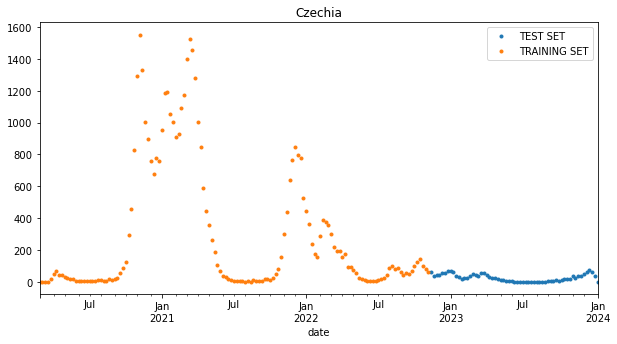

In [109]:
_ = czechia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(czechia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Czechia', style='.')

## basic ARIMA (1,1,1)

In [110]:
model=ARIMA(czechia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -800.674
Date:                Thu, 22 Feb 2024   AIC                           1607.348
Time:                        16:32:50   BIC                           1616.172
Sample:                    03-01-2020   HQIC                          1610.934
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5081      0.054      9.401      0.000       0.402       0.614
ma.L1          0.2949      0.064      4.614      0.000       0.170       0.420
sigma2      5407.8074    339.456     15.931      0.000    4742.486    6073.128
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               175.52
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

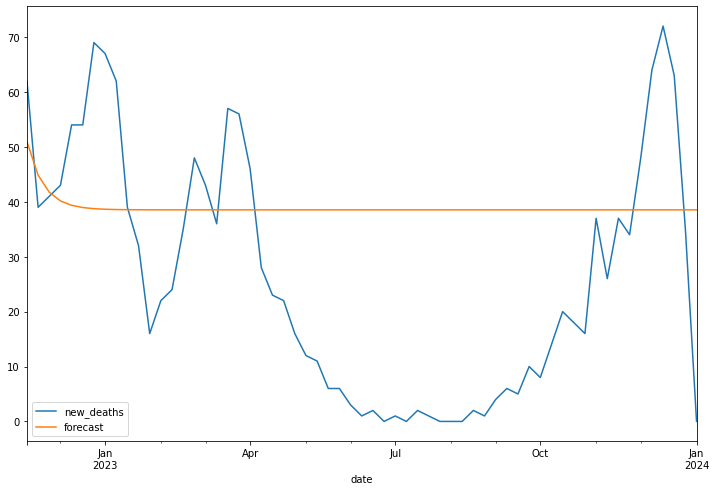

In [111]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [112]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [113]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(czechia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
6,2,3,1601.155974
10,3,3,1602.201856
4,2,1,1602.231170
7,2,4,1602.572989
12,4,1,1603.636664
5,2,2,1604.032261
11,3,4,1604.062748
3,1,4,1604.072284
8,3,1,1604.130403
14,4,3,1605.057628


In [114]:
model=ARIMA(czechia_train['new_deaths'],order=(2,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -794.578
Date:                Thu, 22 Feb 2024   AIC                           1601.156
Time:                        16:33:27   BIC                           1618.806
Sample:                    03-01-2020   HQIC                          1608.328
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4172      0.068     20.869      0.000       1.284       1.550
ar.L2         -0.8575      0.052    -16.454      0.000      -0.960      -0.755
ma.L1         -0.6873      0.080     -8.639      0.000      -0.843      -0.531
ma.L2          0.1716      0.078      2.203      0.028       0.019       0.324
ma.L3          0.3733      0.076      4.909      0.000       0.224       0.522
sigma2      4938.4666    337.631     14.627      0.000    4276.721    5600.212
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               203.33
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

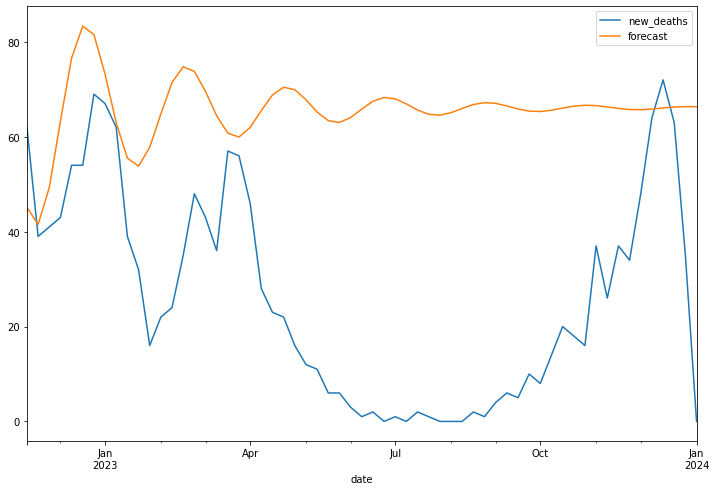

In [115]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [116]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [117]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42984D+00    |proj g|=  1.32483D-01

At iterate    5    f=  5.38079D+00    |proj g|=  3.98670D-03

At iterate   10    f=  5.33322D+00    |proj g|=  9.16109D-02


 This problem is unconstrained.



At iterate   15    f=  5.27969D+00    |proj g|=  4.47835D-03

At iterate   20    f=  5.27966D+00    |proj g|=  1.47891D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   1.083D-05   5.280D+00
  F =   5.2796638671612151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43475D+00    |proj g|=  1.60928D-01


 This problem is unconstrained.



At iterate    5    f=  5.40546D+00    |proj g|=  1.12074D-02

At iterate   10    f=  5.35442D+00    |proj g|=  2.10414D-02

At iterate   15    f=  5.31612D+00    |proj g|=  1.06890D-01

At iterate   20    f=  5.27943D+00    |proj g|=  8.60701D-03

At iterate   25    f=  5.27550D+00    |proj g|=  3.76474D-03

At iterate   30    f=  5.27545D+00    |proj g|=  1.05267D-04

At iterate   35    f=  5.27544D+00    |proj g|=  8.77556D-04

At iterate   40    f=  5.27543D+00    |proj g|=  3.78425D-04

At iterate   45    f=  5.27543D+00    |proj g|=  6.80028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58   

 This problem is unconstrained.



At iterate    5    f=  5.38524D+00    |proj g|=  7.12046D-02

At iterate   10    f=  5.37495D+00    |proj g|=  9.06209D-03

At iterate   15    f=  5.33957D+00    |proj g|=  4.59737D-02

At iterate   20    f=  5.27206D+00    |proj g|=  6.74700D-03

At iterate   25    f=  5.27201D+00    |proj g|=  7.97030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     28      1     0     0   7.127D-05   5.272D+00
  F =   5.2720149863395882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43499D+00    |proj g|=  2.99350D-01

At iterate    5    f=  5.37968D+00    |proj g|=  4.09199D-02

At iterate   10    f=  5.37696D+00    |proj g|=  1.00352D-02

At iterate   15    f=  5.31923D+00    |proj g|=  1.07749D-01

At iterate   20    f=  5.28080D+00    |proj g|=  9.15901D-04

At iterate   25    f=  5.28074D+00    |proj g|=  4.94349D-03

At iterate   30    f=  5.27969D+00    |proj g|=  9.86632D-03

At iterate   35    f=  5.27930D+00    |proj g|=  6.45559D-04

At iterate   40    f=  5.27857D+00    |proj g|=  2.01045D-02

At iterate   45    f=  5.27505D+00    |proj g|=  1.11121D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   10    f=  5.38517D+00    |proj g|=  1.80317D-02

At iterate   15    f=  5.31849D+00    |proj g|=  3.03193D-02

At iterate   20    f=  5.28305D+00    |proj g|=  6.06453D-02

At iterate   25    f=  5.27913D+00    |proj g|=  3.82412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   3.837D-05   5.279D+00
  F =   5.2791299832753324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.41555D+00    |proj g|=  9.90321D-03

At iterate   10    f=  5.36709D+00    |proj g|=  8.55423D-02

At iterate   15    f=  5.33201D+00    |proj g|=  4.48536D-03

At iterate   20    f=  5.32659D+00    |proj g|=  1.47696D-02

At iterate   25    f=  5.29795D+00    |proj g|=  1.48530D-01

At iterate   30    f=  5.27524D+00    |proj g|=  1.94186D-02

At iterate   35    f=  5.27496D+00    |proj g|=  2.85957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     49      1     0     0   8.971D-06   5.275D+00
  F =   5.2749553761714942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.39342D+00    |proj g|=  6.10529D-02

At iterate   10    f=  5.38390D+00    |proj g|=  5.35850D-03

At iterate   15    f=  5.36807D+00    |proj g|=  5.88662D-02

At iterate   20    f=  5.30502D+00    |proj g|=  3.27527D-02

At iterate   25    f=  5.27257D+00    |proj g|=  3.30338D-02

At iterate   30    f=  5.27158D+00    |proj g|=  1.42945D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     38      1     0     0   1.429D-05   5.272D+00
  F =   5.2715772925172306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.38811D+00    |proj g|=  3.86270D-02

At iterate   10    f=  5.38565D+00    |proj g|=  8.84423D-03

At iterate   15    f=  5.37421D+00    |proj g|=  2.64945D-02

At iterate   20    f=  5.32396D+00    |proj g|=  8.81197D-02

At iterate   25    f=  5.28000D+00    |proj g|=  2.11099D-02

At iterate   30    f=  5.27965D+00    |proj g|=  3.39411D-04

At iterate   35    f=  5.27911D+00    |proj g|=  4.84172D-03

At iterate   40    f=  5.27766D+00    |proj g|=  2.81779D-02

At iterate   45    f=  5.27585D+00    |proj g|=  3.34501D-02

At iterate   50    f=  5.27456D+00    |proj g|=  4.98518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.36158D+00    |proj g|=  6.45137D-03

At iterate   10    f=  5.35488D+00    |proj g|=  7.52870D-03

At iterate   15    f=  5.30253D+00    |proj g|=  2.01671D-02

At iterate   20    f=  5.29631D+00    |proj g|=  1.44982D-02

At iterate   25    f=  5.29229D+00    |proj g|=  4.95935D-02

At iterate   30    f=  5.28507D+00    |proj g|=  5.42954D-02

At iterate   35    f=  5.26207D+00    |proj g|=  9.48069D-03

At iterate   40    f=  5.26090D+00    |proj g|=  9.95583D-03

At iterate   45    f=  5.26067D+00    |proj g|=  2.26201D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     64   

 This problem is unconstrained.



At iterate    5    f=  5.38531D+00    |proj g|=  1.12135D-02

At iterate   10    f=  5.35415D+00    |proj g|=  3.10626D-02

At iterate   15    f=  5.29573D+00    |proj g|=  6.32243D-03

At iterate   20    f=  5.29426D+00    |proj g|=  3.99589D-03

At iterate   25    f=  5.28623D+00    |proj g|=  2.97088D-02

At iterate   30    f=  5.26061D+00    |proj g|=  1.56630D-02

At iterate   35    f=  5.25615D+00    |proj g|=  1.99589D-03

At iterate   40    f=  5.25565D+00    |proj g|=  1.71544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     64      1     0     0   1.715D-05   5.256D+00
  F =   5.25564779418

 This problem is unconstrained.



At iterate    5    f=  5.36726D+00    |proj g|=  7.17857D-02

At iterate   10    f=  5.35477D+00    |proj g|=  6.44294D-03

At iterate   15    f=  5.34477D+00    |proj g|=  1.49411D-02

At iterate   20    f=  5.29661D+00    |proj g|=  3.65233D-02

At iterate   25    f=  5.29188D+00    |proj g|=  8.83848D-03

At iterate   30    f=  5.28864D+00    |proj g|=  3.31383D-03
  ys=-1.565E-02  -gs= 5.835E-03 BFGS update SKIPPED

At iterate   35    f=  5.25323D+00    |proj g|=  2.23059D-02

At iterate   40    f=  5.25239D+00    |proj g|=  1.22534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     59      1     1

 This problem is unconstrained.



At iterate    5    f=  5.36074D+00    |proj g|=  4.27323D-02

At iterate   10    f=  5.35704D+00    |proj g|=  1.41541D-02

At iterate   15    f=  5.35220D+00    |proj g|=  9.08097D-03

At iterate   20    f=  5.33685D+00    |proj g|=  3.21643D-02

At iterate   25    f=  5.26133D+00    |proj g|=  1.18255D-02

At iterate   30    f=  5.26101D+00    |proj g|=  1.59771D-03

At iterate   35    f=  5.26006D+00    |proj g|=  1.12037D-02

At iterate   40    f=  5.25864D+00    |proj g|=  1.43907D-02

At iterate   45    f=  5.25522D+00    |proj g|=  4.84982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     70   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41611D+00    |proj g|=  1.29230D-01

At iterate    5    f=  5.36591D+00    |proj g|=  4.13530D-03

At iterate   10    f=  5.35950D+00    |proj g|=  1.53547D-02

At iterate   15    f=  5.31219D+00    |proj g|=  1.03278D-02

At iterate   20    f=  5.26845D+00    |proj g|=  5.60027D-02

At iterate   25    f=  5.26089D+00    |proj g|=  9.46820D-03

At iterate   30    f=  5.26066D+00    |proj g|=  1.54903D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  5.39094D+00    |proj g|=  8.22940D-03

At iterate   10    f=  5.37511D+00    |proj g|=  4.96112D-02

At iterate   15    f=  5.27172D+00    |proj g|=  8.99904D-03

At iterate   20    f=  5.26866D+00    |proj g|=  4.89547D-04

At iterate   25    f=  5.26848D+00    |proj g|=  2.33756D-03

At iterate   30    f=  5.26676D+00    |proj g|=  6.50723D-02

At iterate   35    f=  5.25860D+00    |proj g|=  2.83006D-02

At iterate   40    f=  5.25686D+00    |proj g|=  2.98031D-03

At iterate   45    f=  5.25636D+00    |proj g|=  2.00753D-03

At iterate   50    f=  5.25588D+00    |proj g|=  5.99857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.37109D+00    |proj g|=  6.57309D-02

At iterate   10    f=  5.36012D+00    |proj g|=  4.54153D-03

At iterate   15    f=  5.33457D+00    |proj g|=  4.40894D-02

At iterate   20    f=  5.27118D+00    |proj g|=  1.17260D-02

At iterate   25    f=  5.27090D+00    |proj g|=  2.08567D-03

At iterate   30    f=  5.26865D+00    |proj g|=  3.48921D-02

At iterate   35    f=  5.26655D+00    |proj g|=  2.72725D-03

At iterate   40    f=  5.26654D+00    |proj g|=  5.94221D-05

At iterate   45    f=  5.26654D+00    |proj g|=  1.38836D-03

At iterate   50    f=  5.26649D+00    |proj g|=  1.01653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.36475D+00    |proj g|=  4.02721D-02

At iterate   10    f=  5.36206D+00    |proj g|=  9.01149D-03

At iterate   15    f=  5.34989D+00    |proj g|=  1.65922D-02

At iterate   20    f=  5.27906D+00    |proj g|=  2.93055D-02

At iterate   25    f=  5.27120D+00    |proj g|=  1.82261D-03

At iterate   30    f=  5.26578D+00    |proj g|=  3.25458D-02

At iterate   35    f=  5.26113D+00    |proj g|=  2.03819D-03

At iterate   40    f=  5.26106D+00    |proj g|=  3.50225D-03

At iterate   45    f=  5.26007D+00    |proj g|=  9.80641D-03

At iterate   50    f=  5.25925D+00    |proj g|=  2.24489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [118]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
10,2,1,2,1,1495.173569
8,2,1,1,1,1495.510271
9,2,1,1,2,1496.092678
12,2,2,1,1,1497.507526
11,2,1,2,2,1497.952669
13,2,2,1,2,1498.159424
2,1,1,2,1,1498.708226
0,1,1,1,1,1498.865211
1,1,1,1,2,1499.670581
6,1,2,2,1,1500.584796


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40132D+00    |proj g|=  1.69769D-01


 This problem is unconstrained.



At iterate    5    f=  5.36726D+00    |proj g|=  7.17857D-02

At iterate   10    f=  5.35477D+00    |proj g|=  6.44294D-03

At iterate   15    f=  5.34477D+00    |proj g|=  1.49411D-02

At iterate   20    f=  5.29661D+00    |proj g|=  3.65233D-02

At iterate   25    f=  5.29188D+00    |proj g|=  8.83848D-03

At iterate   30    f=  5.28864D+00    |proj g|=  3.31383D-03
  ys=-1.565E-02  -gs= 5.835E-03 BFGS update SKIPPED

At iterate   35    f=  5.25323D+00    |proj g|=  2.23059D-02

At iterate   40    f=  5.25239D+00    |proj g|=  1.22534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     59      1     1

<AxesSubplot:xlabel='date'>

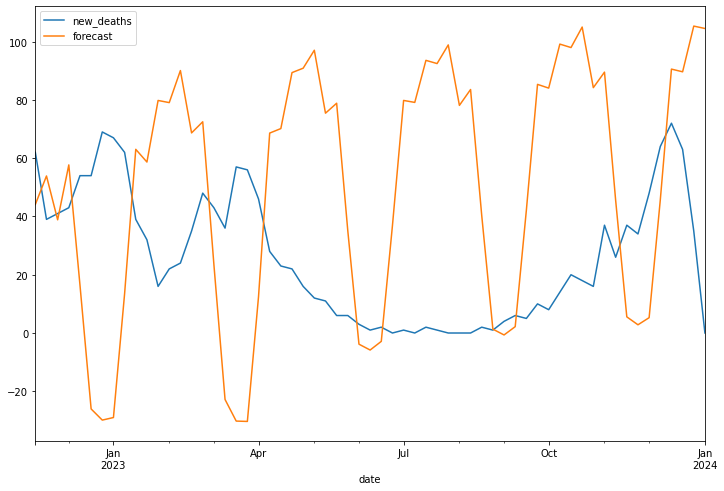

In [119]:
model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
czechia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [120]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
new_row = {'country': 'Czechia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [121]:
auto_model = auto_arima(czechia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(czechia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -802.996
Date:                Thu, 22 Feb 2024   AIC                           1615.993
Time:                        16:35:54   BIC                           1630.736
Sample:                    03-01-2020   HQIC                          1621.984
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2741      0.139     16.311      0.000       2.001       2.547
ar.L2         -1.8294      0.224     -8.160      0.000      -2.269      -1.390
ar.L3          0.5443      0.093      5.879      0.0

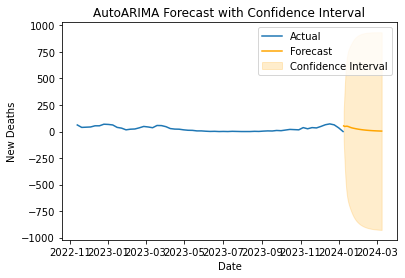

In [122]:
forecast_index = pd.date_range(czechia_test.index[-1], periods=n_periods + 1, freq=czechia_test.index.freq)[-n_periods:]

plt.plot(czechia_test.index, czechia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [123]:
mae = mean_absolute_error(czechia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(czechia_test['new_deaths'], forecast)
r2 = r2_score(czechia_test['new_deaths'], forecast)
new_row = {'country': 'Czechia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Estonia

## train/test split

In [124]:
estonia = pd.read_csv('univariate_df_Estonia.csv')
estonia = estonia.set_index('date')
estonia.index = pd.to_datetime(estonia.index)
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia = estonia.drop('diff1', axis=1)
estonia.sort_index()
train_size = int(len(estonia) * 0.7)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
print(estonia_train.shape, estonia_test.shape)

(141, 1) (61, 1)


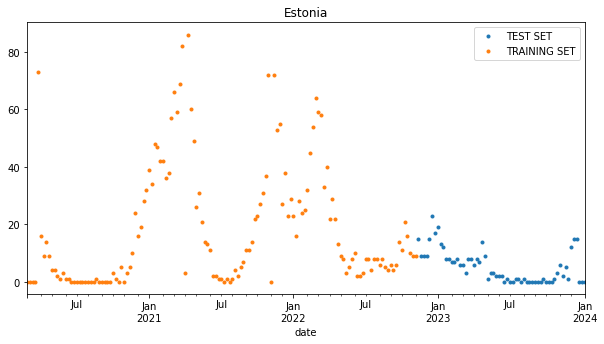

In [125]:
_ = estonia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(estonia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Estonia', style='.')

## basic ARIMA (1,1,1)

In [126]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -566.522
Date:                Thu, 22 Feb 2024   AIC                           1139.044
Time:                        16:37:14   BIC                           1147.869
Sample:                    03-01-2020   HQIC                          1142.630
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3587      0.089     -4.032      0.000      -0.533      -0.184
ma.L1         -0.3083      0.104     -2.963      0.003      -0.512      -0.104
sigma2       190.9689     10.733     17.792      0.000     169.932     212.006
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               542.62
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

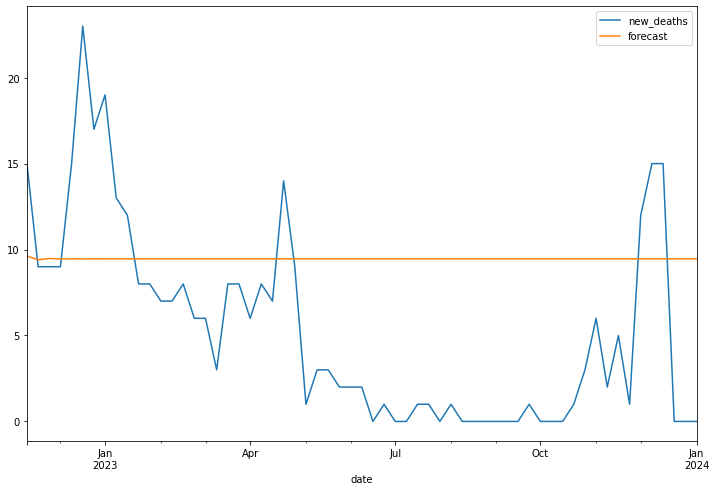

In [127]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [128]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [129]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(estonia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
1,1,2,1138.502611
0,1,1,1139.043778
5,2,2,1140.464763
4,2,1,1140.482547
7,2,4,1140.664562
2,1,3,1140.815389
8,3,1,1141.205140
12,4,1,1141.330897
3,1,4,1141.631094
6,2,3,1141.927197


In [131]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -565.251
Date:                Thu, 22 Feb 2024   AIC                           1138.503
Time:                        16:38:00   BIC                           1150.269
Sample:                    03-01-2020   HQIC                          1143.284
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2369      0.207      1.143      0.253      -0.169       0.643
ma.L1         -0.9234      0.201     -4.599      0.000      -1.317      -0.530
ma.L2          0.4056      0.112      3.613      0.000       0.186       0.626
sigma2       187.3996     10.090     18.572      0.000     167.623     207.176
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               659.67
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

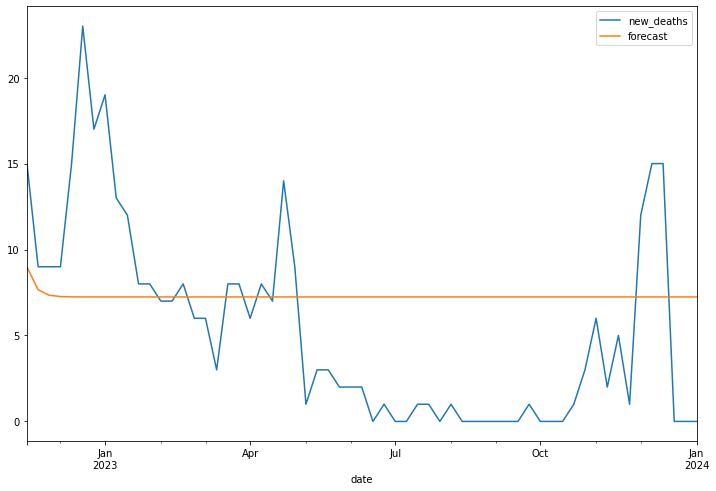

In [132]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [133]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [134]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85826D+00    |proj g|=  7.43585D-02

At iterate    5    f=  3.81304D+00    |proj g|=  1.49804D-02

At iterate   10    f=  3.79146D+00    |proj g|=  1.25568D-03


 This problem is unconstrained.



At iterate   15    f=  3.79142D+00    |proj g|=  8.51139D-05

At iterate   20    f=  3.79141D+00    |proj g|=  2.00637D-03

At iterate   25    f=  3.79140D+00    |proj g|=  5.23179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   4.418D-06   3.791D+00
  F =   3.7914046765830989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81871D+00    |proj g|=  2.23319D-02


 This problem is unconstrained.



At iterate    5    f=  3.80170D+00    |proj g|=  5.03657D-02

At iterate   10    f=  3.79219D+00    |proj g|=  8.89615D-04

At iterate   15    f=  3.79214D+00    |proj g|=  6.27187D-04

At iterate   20    f=  3.79212D+00    |proj g|=  5.23297D-03

At iterate   25    f=  3.79199D+00    |proj g|=  1.28774D-02

At iterate   30    f=  3.79121D+00    |proj g|=  1.86859D-03

At iterate   35    f=  3.79064D+00    |proj g|=  6.69611D-04

At iterate   40    f=  3.79042D+00    |proj g|=  1.00940D-03

At iterate   45    f=  3.79033D+00    |proj g|=  3.11639D-04

At iterate   50    f=  3.79030D+00    |proj g|=  3.23862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.81804D+00    |proj g|=  3.19706D-02

At iterate   10    f=  3.80642D+00    |proj g|=  1.91337D-02

At iterate   15    f=  3.79143D+00    |proj g|=  3.75660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   2.628D-05   3.791D+00
  F =   3.7914070846950509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82152D+00    |proj g|=  2.97245D-02

At iterate    5    f=  3.80268D+00    |proj g|=  1.56206D-02

At iterate   10    f=  3.78820D+00    |proj g|=  1.63769D-03

At iterate   15    f=  3.78774D+00    |proj g|=  5.81716D-03

At iterate   20    f=  3.78713D+00    |proj g|=  1.24538D-03

At iterate   25    f=  3.78707D+00    |proj g|=  1.61389D-03

At iterate   30    f=  3.78701D+00    |proj g|=  1.79292D-04

At iterate   35    f=  3.78700D+00    |proj g|=  4.66395D-04

At iterate   40    f=  3.78700D+00    |proj g|=  2.99406D-04

At iterate   45    f=  3.78699D+00    |proj g|=  4.37112D-04

At iterate   50    f=  3.78699D+00    |proj g|=  1.53847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  3.78571D+00    |proj g|=  1.12356D-02

At iterate   15    f=  3.78188D+00    |proj g|=  1.21250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   2.419D-05   3.782D+00
  F =   3.7818774625910758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81843D+00    |proj g|=  6.46513D-02

At iterate    5    f=  3.79525D+00    |proj g|=  4.10448D-02

At iterate   10    f=  3.78573D+00    |proj g|=  7.08162D-03

At iterate   15    f=  3.78286D+00    |proj g|=  2.94681D-03

At iterate   20    f=  3.78252D+00    |proj g|=  6.24221D-03

At iterate   25    f=  3.78189D+00    |proj g|=  2.31307D-03

At iterate   30    f=  3.78184D+00    |proj g|=  1.97466D-04

At iterate   35    f=  3.78184D+00    |proj g|=  6.83654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  3.81036D+00    |proj g|=  4.80611D-02

At iterate   10    f=  3.79556D+00    |proj g|=  1.78534D-02

At iterate   15    f=  3.78266D+00    |proj g|=  1.47535D-02

At iterate   20    f=  3.78183D+00    |proj g|=  2.74353D-04

At iterate   25    f=  3.78183D+00    |proj g|=  5.08125D-04

At iterate   30    f=  3.78178D+00    |proj g|=  1.00303D-03

At iterate   35    f=  3.78178D+00    |proj g|=  9.02952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     49      1     0     0   3.079D-05   3.782D+00
  F =   3.7817789738699563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82113D+00    |proj g|=  6.24716D-02

At iterate    5    f=  3.80713D+00    |proj g|=  4.34819D-02

At iterate   10    f=  3.78787D+00    |proj g|=  1.76468D-02

At iterate   15    f=  3.77986D+00    |proj g|=  8.14359D-03

At iterate   20    f=  3.77961D+00    |proj g|=  1.67928D-03

At iterate   25    f=  3.77920D+00    |proj g|=  9.45913D-04

At iterate   30    f=  3.77912D+00    |proj g|=  8.62431D-04

At iterate   35    f=  3.77911D+00    |proj g|=  1.37636D-04

At iterate   40    f=  3.77911D+00    |proj g|=  5.50883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  3.79063D+00    |proj g|=  3.38973D-02

At iterate   15    f=  3.78949D+00    |proj g|=  1.54875D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   8.520D-06   3.789D+00
  F =   3.7894859014491380     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81799D+00    |proj g|=  2.25566D-02

At iterate    5    f=  3.80361D+00    |proj g|=  5.69444D-02

At iterate   10    f=  3.79119D+00    |proj g|=  1.47512D-02

At iterate   15    f=  3.79040D+00    |proj g|=  1.10339D-03

At iterate   20    f=  3.79028D+00    |proj g|=  1.89434D-03

At iterate   25    f=  3.79005D+00    |proj g|=  7.01910D-03

At iterate   30    f=  3.78953D+00    |proj g|=  1.21972D-03

At iterate   35    f=  3.78946D+00    |proj g|=  7.86432D-04

At iterate   40    f=  3.78943D+00    |proj g|=  5.10177D-04

At iterate   45    f=  3.78943D+00    |proj g|=  1.07039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.81636D+00    |proj g|=  2.82944D-02

At iterate   10    f=  3.80413D+00    |proj g|=  8.35847D-02

At iterate   15    f=  3.78967D+00    |proj g|=  3.73490D-03

At iterate   20    f=  3.78936D+00    |proj g|=  4.41663D-05

At iterate   25    f=  3.78936D+00    |proj g|=  7.62810D-04

At iterate   30    f=  3.78933D+00    |proj g|=  4.59932D-03

At iterate   35    f=  3.78926D+00    |proj g|=  4.68830D-04

At iterate   40    f=  3.78925D+00    |proj g|=  5.73011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   1.436D-05   3.789D+00
  F =   3.78924550613

 This problem is unconstrained.



At iterate    5    f=  3.81131D+00    |proj g|=  2.46468D-02

At iterate   10    f=  3.78770D+00    |proj g|=  2.23905D-02

At iterate   15    f=  3.78642D+00    |proj g|=  2.48689D-03

At iterate   20    f=  3.78633D+00    |proj g|=  2.43799D-03

At iterate   25    f=  3.78580D+00    |proj g|=  4.40301D-03

At iterate   30    f=  3.78569D+00    |proj g|=  5.19556D-04

At iterate   35    f=  3.78562D+00    |proj g|=  3.82474D-04

At iterate   40    f=  3.78560D+00    |proj g|=  5.26164D-04

At iterate   45    f=  3.78560D+00    |proj g|=  3.75618D-04

At iterate   50    f=  3.78559D+00    |proj g|=  1.88404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.81290D+00    |proj g|=  3.27729D-02

At iterate   10    f=  3.78958D+00    |proj g|=  8.37157D-02

At iterate   15    f=  3.78205D+00    |proj g|=  3.94310D-03

At iterate   20    f=  3.78141D+00    |proj g|=  4.27000D-05

At iterate   25    f=  3.78141D+00    |proj g|=  5.68164D-04

At iterate   30    f=  3.78140D+00    |proj g|=  8.70223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   3.536D-05   3.781D+00
  F =   3.7814041511788088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  3.80831D+00    |proj g|=  3.96995D-02

At iterate   10    f=  3.78429D+00    |proj g|=  2.31163D-02

At iterate   15    f=  3.78324D+00    |proj g|=  3.52644D-03

At iterate   20    f=  3.78287D+00    |proj g|=  7.75228D-03

At iterate   25    f=  3.78246D+00    |proj g|=  2.41124D-03

At iterate   30    f=  3.78241D+00    |proj g|=  4.29492D-03

At iterate   35    f=  3.78158D+00    |proj g|=  6.51749D-03

At iterate   40    f=  3.78142D+00    |proj g|=  1.35454D-03

At iterate   45    f=  3.78138D+00    |proj g|=  2.00095D-04

At iterate   50    f=  3.78138D+00    |proj g|=  1.29236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.81511D+00    |proj g|=  6.72300D-02

At iterate   10    f=  3.79097D+00    |proj g|=  5.38421D-02

At iterate   15    f=  3.78297D+00    |proj g|=  1.41494D-02

At iterate   20    f=  3.78139D+00    |proj g|=  5.56015D-04

At iterate   25    f=  3.78139D+00    |proj g|=  2.02526D-04

At iterate   30    f=  3.78134D+00    |proj g|=  3.33425D-03

At iterate   35    f=  3.78132D+00    |proj g|=  2.09168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     43      1     0     0   4.173D-06   3.781D+00
  F =   3.7813206465092621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.80814D+00    |proj g|=  2.49370D-02

At iterate   10    f=  3.78231D+00    |proj g|=  3.01501D-02

At iterate   15    f=  3.77934D+00    |proj g|=  3.81707D-03

At iterate   20    f=  3.77888D+00    |proj g|=  5.44715D-04

At iterate   25    f=  3.77877D+00    |proj g|=  4.53483D-03

At iterate   30    f=  3.77860D+00    |proj g|=  2.02148D-03

At iterate   35    f=  3.77852D+00    |proj g|=  1.29160D-03

At iterate   40    f=  3.77850D+00    |proj g|=  9.86601D-04

At iterate   45    f=  3.77849D+00    |proj g|=  1.23687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     52   

In [135]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
4,1,2,1,1,1078.489444
0,1,1,1,1,1079.176119
12,2,2,1,1,1080.355971
6,1,2,2,1,1080.461671
5,1,2,1,2,1080.479184
8,2,1,1,1,1080.635024
1,1,1,1,2,1080.864779
2,1,1,2,1,1081.176798
7,1,2,2,2,1081.708740
3,1,1,2,2,1081.932117


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85388D+00    |proj g|=  7.46222D-02

At iterate    5    f=  3.80906D+00    |proj g|=  1.34563D-02

At iterate   10    f=  3.78571D+00    |proj g|=  1.12356D-02

At iterate   15    f=  3.78188D+00    |proj g|=  1.21250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   2.419D-05   3.782D+00
  F =   3.7818774625910758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<AxesSubplot:xlabel='date'>

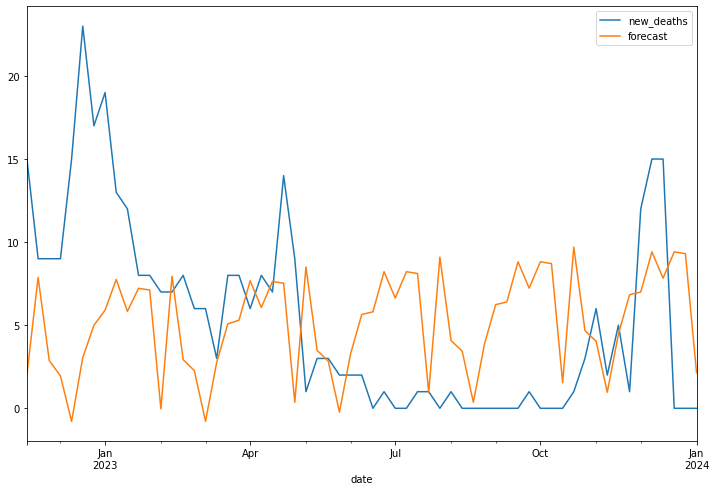

In [136]:
model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(1, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
estonia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [137]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
new_row = {'country': 'Estonia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [138]:
auto_model = auto_arima(estonia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(estonia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -565.368
Date:                Thu, 22 Feb 2024   AIC                           1142.736
Time:                        16:39:55   BIC                           1160.429
Sample:                    03-01-2020   HQIC                          1149.926
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1387      1.400      0.813      0.416      -1.606       3.883
ar.L1          1.5261      0.216      7.071      0.000       1.103       1.949
ar.L2         -0.5945      0.201     -2.956      0.0

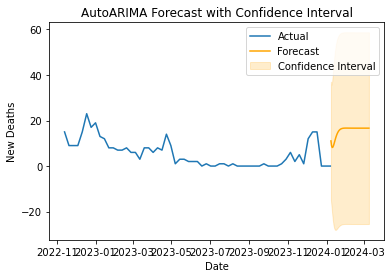

In [139]:
forecast_index = pd.date_range(estonia_test.index[-1], periods=n_periods + 1, freq=estonia_test.index.freq)[-n_periods:]

plt.plot(estonia_test.index, estonia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [140]:
mae = mean_absolute_error(estonia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(estonia_test['new_deaths'], forecast)
r2 = r2_score(estonia_test['new_deaths'], forecast)
new_row = {'country': 'Estonia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# France

## train/test split

In [142]:
france = pd.read_csv('univariate_df_France.csv')
france = france.set_index('date')
france.index = pd.to_datetime(france.index)
france = france.drop('Unnamed: 0', axis=1)
france = france.drop('diff1', axis=1)
france.sort_index()
train_size = int(len(france) * 0.7)
france_train, france_test = france[0:train_size], france[train_size:]
print(france_train.shape, france_test.shape)

(141, 1) (61, 1)


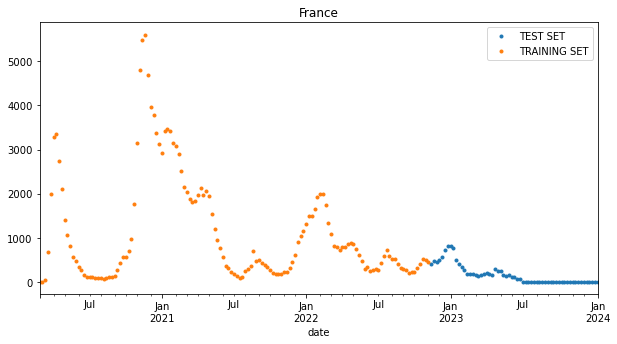

In [143]:
_ = france_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(france_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='France', style='.')

## basic ARIMA (1,1,1)

In [144]:
model=ARIMA(france_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -955.311
Date:                Thu, 22 Feb 2024   AIC                           1916.622
Time:                        16:41:05   BIC                           1925.447
Sample:                    03-01-2020   HQIC                          1920.208
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5745      0.054     10.646      0.000       0.469       0.680
ma.L1          0.3242      0.084      3.868      0.000       0.160       0.489
sigma2      4.922e+04   3363.258     14.635      0.000    4.26e+04    5.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               132.02
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

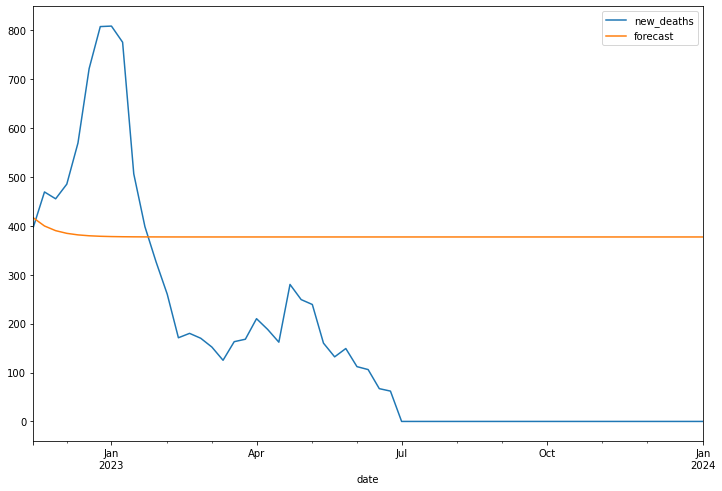

In [145]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [146]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [147]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(france_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
3,1,4,1904.172895
6,2,3,1904.364184
7,2,4,1905.911761
10,3,3,1905.988453
4,2,1,1906.173843
11,3,4,1906.236994
8,3,1,1906.878592
1,1,2,1907.411965
5,2,2,1907.455890
15,4,4,1908.283317


In [148]:
model=ARIMA(france_train['new_deaths'],order=(1,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -946.086
Date:                Thu, 22 Feb 2024   AIC                           1904.173
Time:                        16:41:39   BIC                           1921.823
Sample:                    03-01-2020   HQIC                          1911.345
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8864      0.036     24.431      0.000       0.815       0.958
ma.L1          0.0027      0.140      0.019      0.984      -0.273       0.278
ma.L2         -0.2366      0.107     -2.211      0.027      -0.446      -0.027
ma.L3         -0.4898      0.070     -6.976      0.000      -0.627      -0.352
ma.L4         -0.2763      0.068     -4.080      0.000      -0.409      -0.144
sigma2       4.24e+04   5.89e-06    7.2e+09      0.000    4.24e+04    4.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                86.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.08e+24. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

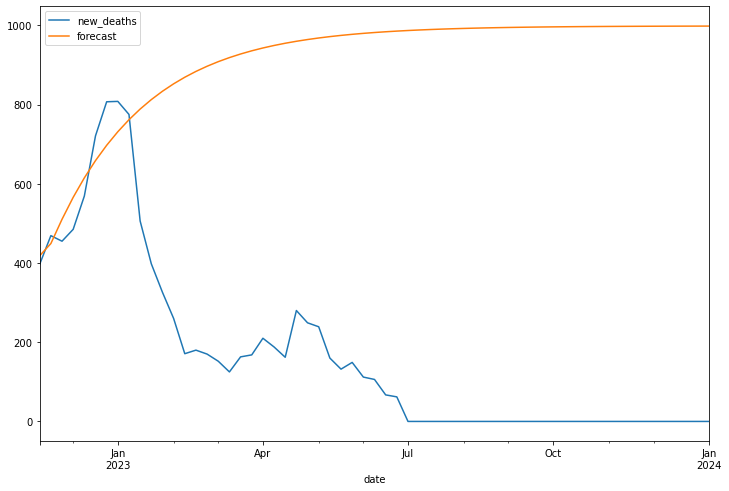

In [149]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [150]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [151]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37308D+00    |proj g|=  1.48557D-01


 This problem is unconstrained.



At iterate    5    f=  6.32848D+00    |proj g|=  1.28405D-02

At iterate   10    f=  6.32674D+00    |proj g|=  1.81051D-03

At iterate   15    f=  6.31371D+00    |proj g|=  8.92099D-02

At iterate   20    f=  6.27302D+00    |proj g|=  1.59561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   5.417D-06   6.273D+00
  F =   6.2730120066352750     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.32708D+00    |proj g|=  1.14365D-03

At iterate   10    f=  6.32629D+00    |proj g|=  1.56708D-02

At iterate   15    f=  6.31312D+00    |proj g|=  2.15955D-02

At iterate   20    f=  6.27472D+00    |proj g|=  5.38159D-03

At iterate   25    f=  6.27464D+00    |proj g|=  5.85836D-03

At iterate   30    f=  6.27377D+00    |proj g|=  2.88993D-03

At iterate   35    f=  6.27191D+00    |proj g|=  1.27891D-02

At iterate   40    f=  6.27149D+00    |proj g|=  9.98081D-05

At iterate   45    f=  6.27147D+00    |proj g|=  1.16460D-03

At iterate   50    f=  6.27144D+00    |proj g|=  5.45085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.33714D+00    |proj g|=  8.71796D-02

At iterate   10    f=  6.32681D+00    |proj g|=  5.33497D-03

At iterate   15    f=  6.32670D+00    |proj g|=  2.75526D-03

At iterate   20    f=  6.30933D+00    |proj g|=  4.51893D-02

At iterate   25    f=  6.27304D+00    |proj g|=  6.67927D-03

At iterate   30    f=  6.27300D+00    |proj g|=  2.24975D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     36      1     0     0   2.250D-05   6.273D+00
  F =   6.2730045541611448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.32685D+00    |proj g|=  1.66919D-03

At iterate   10    f=  6.32662D+00    |proj g|=  3.65939D-03

At iterate   15    f=  6.29757D+00    |proj g|=  9.18900D-02

At iterate   20    f=  6.27297D+00    |proj g|=  1.58674D-03

At iterate   25    f=  6.27287D+00    |proj g|=  2.32439D-04

At iterate   30    f=  6.27287D+00    |proj g|=  2.72934D-04

At iterate   35    f=  6.27281D+00    |proj g|=  3.41084D-03

At iterate   40    f=  6.27279D+00    |proj g|=  1.11005D-03

At iterate   45    f=  6.27276D+00    |proj g|=  5.47898D-04

At iterate   50    f=  6.27275D+00    |proj g|=  2.29119D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.27496D+00    |proj g|=  1.39890D-03

At iterate   15    f=  6.27333D+00    |proj g|=  1.21007D-02

At iterate   20    f=  6.23472D+00    |proj g|=  2.25830D-02

At iterate   25    f=  6.23360D+00    |proj g|=  1.39371D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   6.912D-06   6.234D+00
  F =   6.2336036405026567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30436D+00    |proj g|=  9.14227D-02

At iterate    5    f=  6.27530D+00    |proj g|=  1.50714D-03

At iterate   10    f=  6.27442D+00    |proj g|=  1.24626D-02

At iterate   15    f=  6.24225D+00    |proj g|=  1.48735D-01

At iterate   20    f=  6.23521D+00    |proj g|=  5.82972D-04

At iterate   25    f=  6.23508D+00    |proj g|=  6.67774D-03

At iterate   30    f=  6.23426D+00    |proj g|=  9.99497D-04

At iterate   35    f=  6.23419D+00    |proj g|=  9.02333D-04

At iterate   40    f=  6.23402D+00    |proj g|=  1.19419D-03

At iterate   45    f=  6.23398D+00    |proj g|=  2.03331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32498D+00    |proj g|=  1.50186D-01

At iterate    5    f=  6.27982D+00    |proj g|=  3.97378D-02

At iterate   10    f=  6.27388D+00    |proj g|=  1.11648D-03

At iterate   15    f=  6.27372D+00    |proj g|=  9.60218D-03

At iterate   20    f=  6.25980D+00    |proj g|=  3.63501D-02

At iterate   25    f=  6.23255D+00    |proj g|=  5.91537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.27390D+00    |proj g|=  3.12121D-03

At iterate   10    f=  6.27368D+00    |proj g|=  3.61813D-03

At iterate   15    f=  6.27043D+00    |proj g|=  9.13856D-03

At iterate   20    f=  6.23801D+00    |proj g|=  5.34452D-02

At iterate   25    f=  6.23376D+00    |proj g|=  9.00587D-05

At iterate   30    f=  6.23376D+00    |proj g|=  1.24988D-03

At iterate   35    f=  6.23351D+00    |proj g|=  8.78111D-03

At iterate   40    f=  6.23341D+00    |proj g|=  8.07658D-04

At iterate   45    f=  6.23317D+00    |proj g|=  1.68355D-02

At iterate   50    f=  6.23246D+00    |proj g|=  1.54063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.28428D+00    |proj g|=  3.19711D-02

At iterate   15    f=  6.27688D+00    |proj g|=  5.60580D-03

At iterate   20    f=  6.27671D+00    |proj g|=  2.35323D-03

At iterate   25    f=  6.26621D+00    |proj g|=  3.75323D-02

At iterate   30    f=  6.22741D+00    |proj g|=  7.93438D-03

At iterate   35    f=  6.22536D+00    |proj g|=  4.20950D-03

At iterate   40    f=  6.22484D+00    |proj g|=  1.69789D-03

At iterate   45    f=  6.22478D+00    |proj g|=  1.65814D-04

At iterate   50    f=  6.22477D+00    |proj g|=  7.26918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57   

 This problem is unconstrained.



At iterate    5    f=  6.30382D+00    |proj g|=  1.21340D-02

At iterate   10    f=  6.29671D+00    |proj g|=  2.88765D-02

At iterate   15    f=  6.27906D+00    |proj g|=  8.27456D-03

At iterate   20    f=  6.27870D+00    |proj g|=  3.31803D-03

At iterate   25    f=  6.27121D+00    |proj g|=  7.24431D-02

At iterate   30    f=  6.26164D+00    |proj g|=  1.71151D-02

At iterate   35    f=  6.22813D+00    |proj g|=  1.44678D-04

At iterate   40    f=  6.22812D+00    |proj g|=  1.64874D-03

At iterate   45    f=  6.22752D+00    |proj g|=  1.60323D-03

At iterate   50    f=  6.22495D+00    |proj g|=  1.83160D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38043D+00    |proj g|=  1.78578D-01

At iterate    5    f=  6.30783D+00    |proj g|=  3.67823D-02

At iterate   10    f=  6.28418D+00    |proj g|=  1.91977D-02

At iterate   15    f=  6.27608D+00    |proj g|=  3.09590D-02

At iterate   20    f=  6.27463D+00    |proj g|=  1.22386D-03

At iterate   25    f=  6.27192D+00    |proj g|=  2.25504D-02

At iterate   30    f=  6.24110D+00    |proj g|=  4.04523D-02

At iterate   35    f=  6.22264D+00    |proj g|=  1.05248D-02

At iterate   40    f=  6.22223D+00    |proj g|=  4.29232D-05

At iterate   45    f=  6.22223D+00    |proj g|=  9.00355D-04

At iterate   50    f=  6.22221D+00    |proj g|=  3.18541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.30282D+00    |proj g|=  9.55428D-03

At iterate   10    f=  6.28764D+00    |proj g|=  8.11918D-02

At iterate   15    f=  6.27471D+00    |proj g|=  1.22471D-03

At iterate   20    f=  6.27444D+00    |proj g|=  1.07606D-02

At iterate   25    f=  6.24288D+00    |proj g|=  1.17964D-01

At iterate   30    f=  6.22769D+00    |proj g|=  1.44720D-03

At iterate   35    f=  6.22717D+00    |proj g|=  1.02783D-02

At iterate   40    f=  6.22468D+00    |proj g|=  4.21442D-03

At iterate   45    f=  6.22444D+00    |proj g|=  9.88452D-04

At iterate   50    f=  6.22398D+00    |proj g|=  1.68025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32625D+00    |proj g|=  1.64531D-01

At iterate    5    f=  6.26502D+00    |proj g|=  3.36859D-02

At iterate   10    f=  6.26261D+00    |proj g|=  1.76544D-03

At iterate   15    f=  6.26247D+00    |proj g|=  3.50574D-03

At iterate   20    f=  6.26221D+00    |proj g|=  9.38476D-03

At iterate   25    f=  6.24875D+00    |proj g|=  5.18726D-02

At iterate   30    f=  6.22645D+00    |proj g|=  1.40941D-02

At iterate   35    f=  6.22397D+00    |proj g|=  4.70360D-03

At iterate   40    f=  6.22319D+00    |proj g|=  1.39766D-02

At iterate   45    f=  6.22296D+00    |proj g|=  1.02020D-03

At iterate   50    f=  6.22288D+00    |proj g|=  5.18533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29498D+00    |proj g|=  1.19158D-01

At iterate    5    f=  6.26319D+00    |proj g|=  1.04189D-02

At iterate   10    f=  6.26292D+00    |proj g|=  2.83832D-03

At iterate   15    f=  6.26262D+00    |proj g|=  6.95533D-03

At iterate   20    f=  6.25857D+00    |proj g|=  1.16173D-02

At iterate   25    f=  6.22684D+00    |proj g|=  2.35256D-02

At iterate   30    f=  6.22435D+00    |proj g|=  2.47069D-02

At iterate   35    f=  6.22356D+00    |proj g|=  1.54894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31597D+00    |proj g|=  1.56962D-01

At iterate    5    f=  6.27175D+00    |proj g|=  3.58212D-02

At iterate   10    f=  6.26041D+00    |proj g|=  3.40042D-03

At iterate   15    f=  6.26028D+00    |proj g|=  4.82183D-03

At iterate   20    f=  6.25651D+00    |proj g|=  2.71454D-02

At iterate   25    f=  6.25182D+00    |proj g|=  7.94435D-03

At iterate   30    f=  6.23518D+00    |proj g|=  4.02576D-02

At iterate   35    f=  6.22107D+00    |proj g|=  1.13921D-02

At iterate   40    f=  6.22053D+00    |proj g|=  6.33789D-04

At iterate   45    f=  6.22051D+00    |proj g|=  3.86069D-04

At iterate   50    f=  6.22048D+00    |proj g|=  2.18733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.26047D+00    |proj g|=  1.11981D-02

At iterate   10    f=  6.26005D+00    |proj g|=  5.29436D-03

At iterate   15    f=  6.25973D+00    |proj g|=  1.51532D-03

At iterate   20    f=  6.25956D+00    |proj g|=  5.09290D-03

At iterate   25    f=  6.24019D+00    |proj g|=  5.42968D-02

At iterate   30    f=  6.21972D+00    |proj g|=  6.20366D-03

At iterate   35    f=  6.21941D+00    |proj g|=  2.10061D-03

At iterate   40    f=  6.21864D+00    |proj g|=  1.03972D-02

At iterate   45    f=  6.21847D+00    |proj g|=  6.47407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     55   

In [152]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1767.385595
10,2,1,2,1,1768.663736
12,2,2,1,1,1768.853466
9,2,1,1,2,1769.436853
4,1,2,1,1,1769.876227
14,2,2,2,1,1770.175076
13,2,2,1,2,1771.042543
11,2,1,2,2,1771.162086
6,1,2,2,1,1771.571149
15,2,2,2,2,1771.607836


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38925D+00    |proj g|=  1.82597D-01

At iterate    5    f=  6.30472D+00    |proj g|=  2.19801D-02


 This problem is unconstrained.



At iterate   10    f=  6.28428D+00    |proj g|=  3.19711D-02

At iterate   15    f=  6.27688D+00    |proj g|=  5.60580D-03

At iterate   20    f=  6.27671D+00    |proj g|=  2.35323D-03

At iterate   25    f=  6.26621D+00    |proj g|=  3.75323D-02

At iterate   30    f=  6.22741D+00    |proj g|=  7.93438D-03

At iterate   35    f=  6.22536D+00    |proj g|=  4.20950D-03

At iterate   40    f=  6.22484D+00    |proj g|=  1.69789D-03

At iterate   45    f=  6.22478D+00    |proj g|=  1.65814D-04

At iterate   50    f=  6.22477D+00    |proj g|=  7.26918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57   

<AxesSubplot:xlabel='date'>

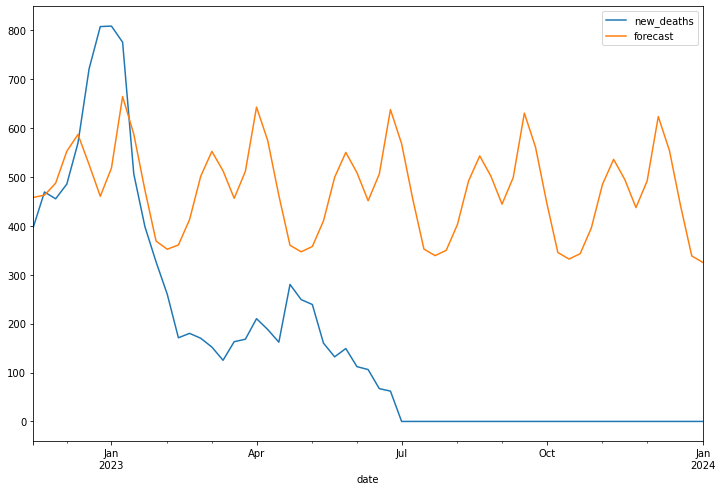

In [153]:
model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
france_test['forecast']=results.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [154]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
mape = mean_absolute_percentage_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
new_row = {'country': 'France', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [155]:
auto_model = auto_arima(france_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(france_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -953.040
Date:                Thu, 22 Feb 2024   AIC                           1918.081
Time:                        16:43:37   BIC                           1935.773
Sample:                    03-01-2020   HQIC                          1925.270
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.6837     63.218      1.482      0.138     -30.222     217.589
ar.L1          1.3268      0.075     17.717      0.000       1.180       1.474
ar.L2         -0.4172      0.073     -5.715      0.0

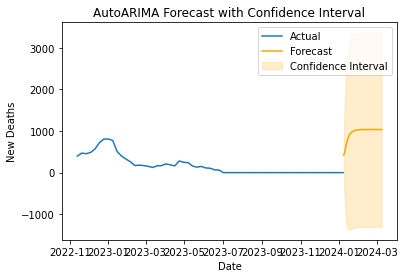

In [156]:
forecast_index = pd.date_range(france_test.index[-1], periods=n_periods + 1, freq=france_test.index.freq)[-n_periods:]

plt.plot(france_test.index, france_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [157]:
mae = mean_absolute_error(france_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(france_test['new_deaths'], forecast)
r2 = r2_score(france_test['new_deaths'], forecast)
new_row = {'country': 'France', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Malaysia

## train/test split

In [158]:
malaysia = pd.read_csv('univariate_df_Malaysia.csv')
malaysia = malaysia.set_index('date')
malaysia.index = pd.to_datetime(malaysia.index)
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia = malaysia.drop('diff1', axis=1)
malaysia.sort_index()
train_size = int(len(malaysia) * 0.7)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
print(malaysia_train.shape, malaysia_test.shape)

(141, 1) (61, 1)


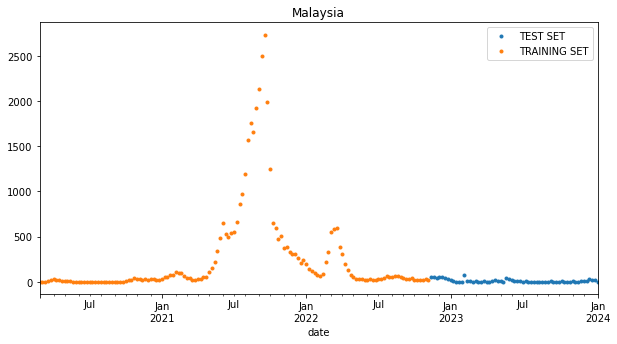

In [159]:
_ = malaysia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(malaysia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Malaysia', style='.')

## basic ARIMA (1,1,1)

In [160]:
model=ARIMA(malaysia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -849.761
Date:                Thu, 22 Feb 2024   AIC                           1705.521
Time:                        16:45:40   BIC                           1714.346
Sample:                    03-01-2020   HQIC                          1709.108
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4641      0.065      7.148      0.000       0.337       0.591
ma.L1          0.1839      0.077      2.376      0.017       0.032       0.336
sigma2      1.092e+04    443.854     24.606      0.000    1.01e+04    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              6050.75
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              29.24   Skew:                            -3.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

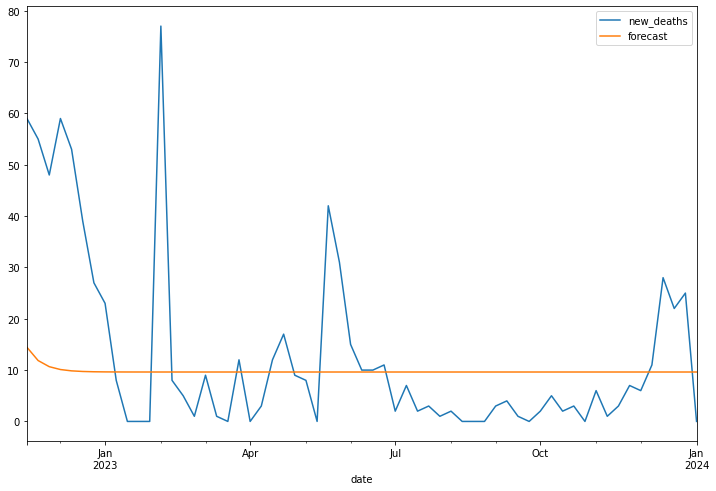

In [161]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [162]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'Basic ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [163]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(malaysia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
9,3,2,1693.222428
6,2,3,1693.416992
11,3,4,1694.127175
5,2,2,1694.471179
7,2,4,1695.208367
13,4,2,1695.221904
10,3,3,1695.222291
15,4,4,1695.554666
14,4,3,1696.944360
3,1,4,1697.775995


In [164]:
model=ARIMA(malaysia_train['new_deaths'],order=(3,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -840.611
Date:                Thu, 22 Feb 2024   AIC                           1693.222
Time:                        16:46:02   BIC                           1710.872
Sample:                    03-01-2020   HQIC                          1700.395
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6827      0.124      5.491      0.000       0.439       0.926
ar.L2         -0.7409      0.151     -4.919      0.000      -1.036      -0.446
ar.L3          0.2037      0.083      2.459      0.014       0.041       0.366
ma.L1         -0.0162      0.120     -0.135      0.892      -0.251       0.219
ma.L2          0.7713      0.104      7.401      0.000       0.567       0.976
sigma2      9532.6325    527.536     18.070      0.000    8498.681    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4852.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              23.29   Skew:                            -3.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

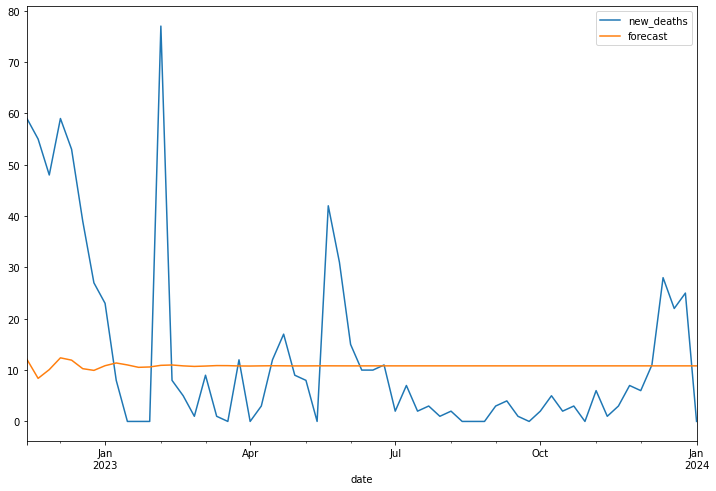

In [165]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [166]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [167]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72783D+00    |proj g|=  8.38039D-02

At iterate    5    f=  5.70150D+00    |proj g|=  1.79991D-02


 This problem is unconstrained.



At iterate   10    f=  5.69655D+00    |proj g|=  1.11138D-02

At iterate   15    f=  5.60393D+00    |proj g|=  9.33492D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.197D-05   5.604D+00
  F =   5.6038316381249551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71812D+00    |proj g|=  3.90503D-02


 This problem is unconstrained.



At iterate    5    f=  5.70368D+00    |proj g|=  2.95921D-02

At iterate   10    f=  5.69974D+00    |proj g|=  3.50795D-03

At iterate   15    f=  5.69095D+00    |proj g|=  4.75637D-02

At iterate   20    f=  5.60989D+00    |proj g|=  7.04208D-02

At iterate   25    f=  5.60474D+00    |proj g|=  1.68488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     37      1     0     0   1.326D-05   5.605D+00
  F =   5.6047429592021150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  5.71369D+00    |proj g|=  5.33493D-02

At iterate   10    f=  5.69837D+00    |proj g|=  3.60546D-03

At iterate   15    f=  5.69460D+00    |proj g|=  1.40582D-02

At iterate   20    f=  5.60256D+00    |proj g|=  3.12522D-02

At iterate   25    f=  5.60178D+00    |proj g|=  3.08072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   2.535D-06   5.602D+00
  F =   5.6017810215065271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.69957D+00    |proj g|=  1.33031D-02

At iterate   10    f=  5.69834D+00    |proj g|=  8.66639D-03

At iterate   15    f=  5.65412D+00    |proj g|=  3.96805D-02

At iterate   20    f=  5.60632D+00    |proj g|=  5.96064D-03

At iterate   25    f=  5.60613D+00    |proj g|=  5.59106D-03

At iterate   30    f=  5.60350D+00    |proj g|=  9.47578D-03

At iterate   35    f=  5.60171D+00    |proj g|=  2.77941D-02

At iterate   40    f=  5.59909D+00    |proj g|=  1.54173D-03

At iterate   45    f=  5.59907D+00    |proj g|=  1.67967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     57   

 This problem is unconstrained.



At iterate    5    f=  5.67651D+00    |proj g|=  3.72554D-02

At iterate   10    f=  5.67264D+00    |proj g|=  2.81428D-03

At iterate   15    f=  5.64679D+00    |proj g|=  5.13154D-02

At iterate   20    f=  5.60802D+00    |proj g|=  6.51456D-02

At iterate   25    f=  5.58265D+00    |proj g|=  4.98620D-03

At iterate   30    f=  5.58258D+00    |proj g|=  2.87248D-04

At iterate   35    f=  5.58256D+00    |proj g|=  3.80946D-03

At iterate   40    f=  5.58246D+00    |proj g|=  7.04476D-04

At iterate   45    f=  5.58246D+00    |proj g|=  1.21476D-03

At iterate   50    f=  5.58244D+00    |proj g|=  2.06858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68344D+00    |proj g|=  4.87013D-02

At iterate   10    f=  5.67362D+00    |proj g|=  1.83870D-02

At iterate   15    f=  5.67209D+00    |proj g|=  3.38934D-03

At iterate   20    f=  5.66244D+00    |proj g|=  3.96510D-02

At iterate   25    f=  5.62503D+00    |proj g|=  6.28831D-02

At iterate   30    f=  5.58785D+00    |proj g|=  5.09299D-02

At iterate   35    f=  5.58263D+00    |proj g|=  1.22058D-03

At iterate   40    f=  5.58250D+00    |proj g|=  3.28773D-03

At iterate   45    f=  5.58247D+00    |proj g|=  2.05781D-04

At iterate   50    f=  5.58245D+00    |proj g|=  2.25100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68873D+00    |proj g|=  8.07722D-02

At iterate   10    f=  5.67201D+00    |proj g|=  1.22626D-02

At iterate   15    f=  5.67086D+00    |proj g|=  3.31624D-03

At iterate   20    f=  5.62348D+00    |proj g|=  5.94968D-02

At iterate   25    f=  5.58105D+00    |proj g|=  1.06315D-02

At iterate   30    f=  5.58094D+00    |proj g|=  1.24219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   2.603D-06   5.581D+00
  F =   5.5809369055701090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.67271D+00    |proj g|=  2.22228D-02

At iterate   10    f=  5.67134D+00    |proj g|=  3.27425D-03

At iterate   15    f=  5.66601D+00    |proj g|=  3.93489D-02

At iterate   20    f=  5.59178D+00    |proj g|=  6.24095D-02

At iterate   25    f=  5.58324D+00    |proj g|=  1.12396D-03

At iterate   30    f=  5.58274D+00    |proj g|=  1.64849D-02

At iterate   35    f=  5.57871D+00    |proj g|=  2.73783D-02

At iterate   40    f=  5.57637D+00    |proj g|=  3.95727D-03

At iterate   45    f=  5.57624D+00    |proj g|=  3.95207D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     55   

 This problem is unconstrained.



At iterate    5    f=  5.68457D+00    |proj g|=  1.26400D-02

At iterate   10    f=  5.68239D+00    |proj g|=  8.51563D-03

At iterate   15    f=  5.68003D+00    |proj g|=  1.49075D-02

At iterate   20    f=  5.62476D+00    |proj g|=  6.88373D-02

At iterate   25    f=  5.59430D+00    |proj g|=  2.16523D-02

At iterate   30    f=  5.59290D+00    |proj g|=  8.28955D-03

At iterate   35    f=  5.59192D+00    |proj g|=  7.31297D-04

At iterate   40    f=  5.59174D+00    |proj g|=  3.39472D-04

At iterate   45    f=  5.59172D+00    |proj g|=  5.30527D-04

At iterate   50    f=  5.59172D+00    |proj g|=  2.06577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68803D+00    |proj g|=  3.97073D-02

At iterate   10    f=  5.68321D+00    |proj g|=  3.85682D-03

At iterate   15    f=  5.68089D+00    |proj g|=  6.32792D-03

At iterate   20    f=  5.67402D+00    |proj g|=  2.81152D-02

At iterate   25    f=  5.61215D+00    |proj g|=  1.67715D-01

At iterate   30    f=  5.59264D+00    |proj g|=  2.83592D-04

At iterate   35    f=  5.59263D+00    |proj g|=  7.60869D-04

At iterate   40    f=  5.59255D+00    |proj g|=  3.37033D-03

At iterate   45    f=  5.59249D+00    |proj g|=  1.74622D-03

At iterate   50    f=  5.59243D+00    |proj g|=  1.30891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.69631D+00    |proj g|=  4.45135D-02

At iterate   10    f=  5.68144D+00    |proj g|=  4.94202D-03

At iterate   15    f=  5.68000D+00    |proj g|=  4.61830D-03

At iterate   20    f=  5.67547D+00    |proj g|=  3.75382D-02

At iterate   25    f=  5.60082D+00    |proj g|=  6.05762D-02

At iterate   30    f=  5.59200D+00    |proj g|=  1.56273D-02

At iterate   35    f=  5.59055D+00    |proj g|=  8.39836D-03

At iterate   40    f=  5.58996D+00    |proj g|=  8.48203D-04

At iterate   45    f=  5.58988D+00    |proj g|=  1.83471D-03

At iterate   50    f=  5.58986D+00    |proj g|=  1.35815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68361D+00    |proj g|=  1.32288D-02

At iterate   10    f=  5.68054D+00    |proj g|=  7.07157D-03

At iterate   15    f=  5.67879D+00    |proj g|=  1.60889D-02

At iterate   20    f=  5.63303D+00    |proj g|=  6.71649D-02

At iterate   25    f=  5.59252D+00    |proj g|=  9.40618D-04

At iterate   30    f=  5.59177D+00    |proj g|=  6.98438D-03

At iterate   35    f=  5.58887D+00    |proj g|=  2.16384D-02

At iterate   40    f=  5.58682D+00    |proj g|=  2.08124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     56      1     0     0   3.950D-05   5.587D+00
  F =   5.58681373851

 This problem is unconstrained.



At iterate    5    f=  5.66856D+00    |proj g|=  3.44811D-02

At iterate   10    f=  5.66010D+00    |proj g|=  1.60553D-02

At iterate   15    f=  5.65948D+00    |proj g|=  6.68389D-03

At iterate   20    f=  5.65861D+00    |proj g|=  1.93714D-02

At iterate   25    f=  5.64709D+00    |proj g|=  2.17760D-02

At iterate   30    f=  5.61311D+00    |proj g|=  2.90317D-01

At iterate   35    f=  5.60360D+00    |proj g|=  7.01507D-03

At iterate   40    f=  5.58251D+00    |proj g|=  1.02542D-01

At iterate   45    f=  5.56039D+00    |proj g|=  7.53134D-02

At iterate   50    f=  5.55906D+00    |proj g|=  2.95329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.67305D+00    |proj g|=  1.84729D-02

At iterate   10    f=  5.66135D+00    |proj g|=  1.34377D-02

At iterate   15    f=  5.65901D+00    |proj g|=  3.53505D-03

At iterate   20    f=  5.65796D+00    |proj g|=  1.58880D-02

At iterate   25    f=  5.61862D+00    |proj g|=  3.65256D-02

At iterate   30    f=  5.56148D+00    |proj g|=  5.46021D-02

At iterate   35    f=  5.55993D+00    |proj g|=  1.28043D-03

At iterate   40    f=  5.55993D+00    |proj g|=  1.03173D-03

At iterate   45    f=  5.55987D+00    |proj g|=  1.11203D-02

At iterate   50    f=  5.55947D+00    |proj g|=  5.85020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68279D+00    |proj g|=  3.17351D-02

At iterate   10    f=  5.66405D+00    |proj g|=  4.66661D-02

At iterate   15    f=  5.65801D+00    |proj g|=  7.17375D-03

At iterate   20    f=  5.65699D+00    |proj g|=  9.45448D-03

At iterate   25    f=  5.62934D+00    |proj g|=  6.75421D-02

At iterate   30    f=  5.56115D+00    |proj g|=  1.58980D-02

At iterate   35    f=  5.55928D+00    |proj g|=  3.31814D-03

At iterate   40    f=  5.55839D+00    |proj g|=  5.04357D-03

At iterate   45    f=  5.55790D+00    |proj g|=  4.94472D-03

At iterate   50    f=  5.55786D+00    |proj g|=  1.72959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.66250D+00    |proj g|=  1.96567D-02

At iterate   10    f=  5.65841D+00    |proj g|=  2.32034D-02

At iterate   15    f=  5.65790D+00    |proj g|=  2.94400D-03

At iterate   20    f=  5.65619D+00    |proj g|=  1.99183D-02

At iterate   25    f=  5.62177D+00    |proj g|=  1.13223D-01

At iterate   30    f=  5.56349D+00    |proj g|=  1.95712D-02

At iterate   35    f=  5.56210D+00    |proj g|=  3.28166D-02

At iterate   40    f=  5.55860D+00    |proj g|=  3.21043D-03

At iterate   45    f=  5.55721D+00    |proj g|=  1.72535D-02

At iterate   50    f=  5.55214D+00    |proj g|=  1.87392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [168]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1581.654862
14,2,2,2,1,1583.317067
15,2,2,2,2,1583.703199
13,2,2,1,2,1583.770900
4,1,2,1,1,1586.246825
6,1,2,2,1,1587.824207
5,1,2,1,2,1588.250130
7,1,2,2,2,1588.499386
8,2,1,1,1,1588.864739
0,1,1,1,1,1590.280522


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71956D+00    |proj g|=  1.72006D-01

At iterate    5    f=  5.66856D+00    |proj g|=  3.44811D-02

At iterate   10    f=  5.66010D+00    |proj g|=  1.60553D-02

At iterate   15    f=  5.65948D+00    |proj g|=  6.68389D-03

At iterate   20    f=  5.65861D+00    |proj g|=  1.93714D-02

At iterate   25    f=  5.64709D+00    |proj g|=  2.17760D-02

At iterate   30    f=  5.61311D+00    |proj g|=  2.90317D-01

At iterate   35    f=  5.60360D+00    |proj g|=  7.01507D-03

At iterate   40    f=  5.58251D+00    |proj g|=  1.02542D-01

At iterate   45    f=  5.56039D+00    |proj g|=  7.53134D-02

At iterate   50    f=  5.55906D+00    |proj g|=  2.95329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

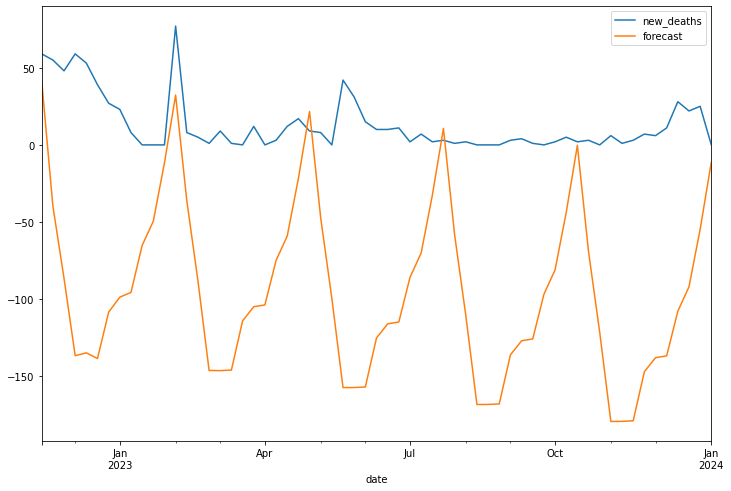

In [169]:
model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(2, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
malaysia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [170]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
new_row = {'country': 'Malaysia', 'model': 'SARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [171]:
auto_model = auto_arima(malaysia_train['new_deaths'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(malaysia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -845.496
Date:                Thu, 22 Feb 2024   AIC                           1704.992
Time:                        16:47:48   BIC                           1725.633
Sample:                    03-01-2020   HQIC                          1713.380
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6429      0.121     13.604      0.000       1.406       1.880
ar.L2         -1.4184      0.246     -5.762      0.000      -1.901      -0.936
ar.L3          0.9487      0.225      4.212      0.0

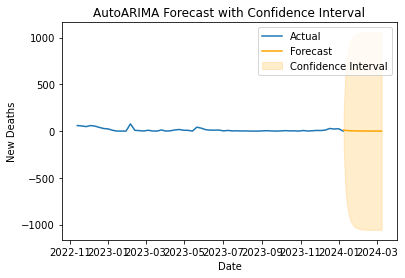

In [172]:
forecast_index = pd.date_range(malaysia_test.index[-1], periods=n_periods + 1, freq=malaysia_test.index.freq)[-n_periods:]

plt.plot(malaysia_test.index, malaysia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [173]:
mae = mean_absolute_error(malaysia_test['new_deaths'], forecast)
mape = mean_absolute_percentage_error(malaysia_test['new_deaths'], forecast)
r2 = r2_score(malaysia_test['new_deaths'], forecast)
new_row = {'country': 'Malaysia', 'model': 'autoARIMA', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [174]:
# metrics
metrics.sort_values('mape')

,country,model,mae,mape,rsq
2,Belgium,SARIMA,21.060196,11170345088958.0,-0.539543
14,Israel,SARIMA,13.612985,843359300639157.875,-0.851942
39,Malaysia,autoARIMA,11.849371,1331605873016298.75,-0.213478
10,Ireland,SARIMA,16.186868,1955924009827931.0,-0.614227
8,Ireland,Basic ARIMA,34.795491,4042226737581222.0,-5.670918
9,Ireland,Grid Search ARIMA,36.663036,4176189233094341.0,-6.424504
11,Ireland,autoARIMA,37.465554,4227009816931680.5,-6.693097
27,Czechia,autoARIMA,14.866394,4945853891395338.0,0.168512
30,Estonia,SARIMA,5.33304,7295077803311993.0,-0.375512
36,Malaysia,Basic ARIMA,11.945929,8529135955959590.0,0.003771
